# HPV18

### Imports y lectura de resultados de Cell Ranger

In [1]:
import anndata
import matplotlib.pyplot as plt
import numpy as np
import pooch
import scanpy as sc
import pandas as pd
import scrublet as scr
from sklearn.metrics import silhouette_score
import seaborn as sns
from scipy import sparse
import itertools

In [2]:
adata = sc.read_10x_mtx('../RAW/hpv18', var_names='gene_symbols', cache=True)

In [3]:
sc.pp.calculate_qc_metrics(adata)

/home/akim/Desktop/TFM/venv/tfm/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


(                    n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
 AAACCTGAGAATGTTG-1               3440                 8.143517       12703.0   
 AAACGGGAGCCCAACC-1               1748                 7.466799        3380.0   
 AAACGGGAGGTACTCT-1               3104                 8.040769       12050.0   
 AAACGGGCACTCGACG-1               3365                 8.121480       13793.0   
 AAACGGGCAGGGTATG-1               5118                 8.540714       18786.0   
 ...                               ...                      ...           ...   
 TTTGGTTCATGCATGT-1                703                 6.556778        1504.0   
 TTTGGTTGTGATAAAC-1               2859                 7.958577       10569.0   
 TTTGGTTTCAGTTGAC-1                647                 6.473891        1100.0   
 TTTGTCAGTCTTTCAT-1                341                 5.834811         624.0   
 TTTGTCAGTGATAAAC-1                492                 6.200509         818.0   
 
                     log1p

                    n_genes_by_counts  total_counts  pct_counts_mt
AAACCTGAGAATGTTG-1               3440       12703.0       1.385499
AAACGGGAGCCCAACC-1               1748        3380.0      22.455620
AAACGGGAGGTACTCT-1               3104       12050.0       4.107884
AAACGGGCACTCGACG-1               3365       13793.0       1.674763
AAACGGGCAGGGTATG-1               5118       18786.0       2.608325


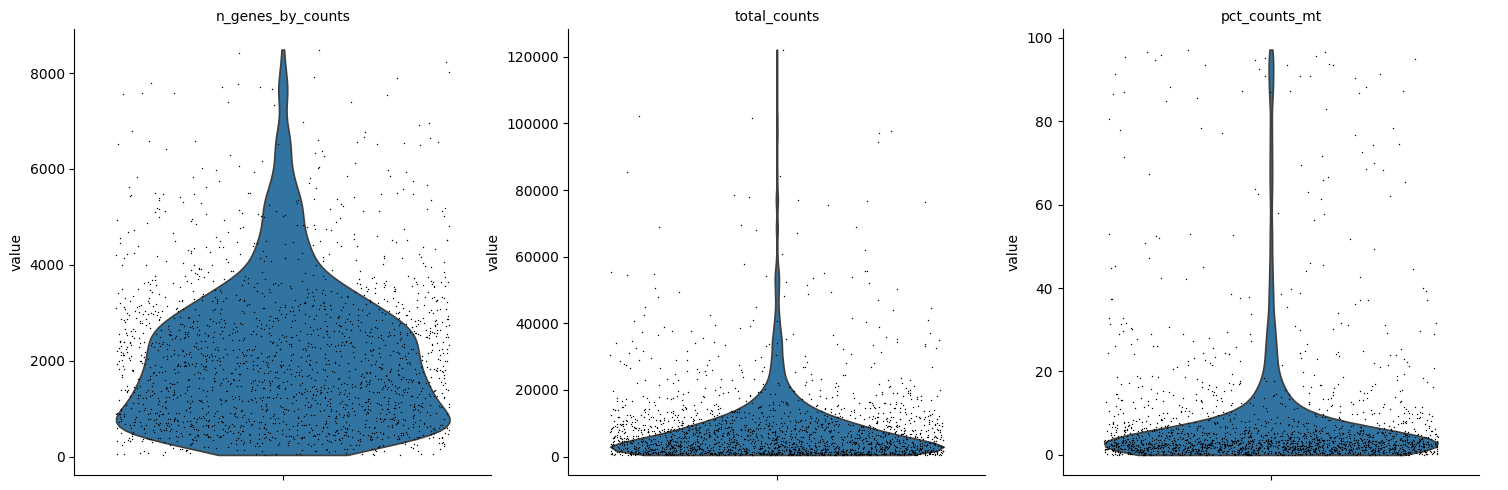

In [4]:
# Calcular el número de genes detectados por célula
adata.obs['n_genes_by_counts'] = (adata.X > 0).sum(axis=1).A1  # Convierte a vector 1D si es una matriz dispersa

# Calcular el total de UMIs por célula
adata.obs['total_counts'] = adata.X.sum(axis=1).A1

# Calcular el porcentaje de ARN mitocondrial
# Identificar genes mitocondriales (puedes ajustar el prefijo 'MT-' según tu anotación de genes)
mito_genes = adata.var_names.str.startswith('MT-')

# Sumar la expresión de genes mitocondriales por célula
adata.obs['pct_counts_mt'] = (adata[:, mito_genes].X.sum(axis=1).A1 / adata.obs['total_counts']) * 100

# Revisar las columnas recién creadas
print(adata.obs[['n_genes_by_counts', 'total_counts', 'pct_counts_mt']].head())

# Generar gráficos de violín para las métricas calculadas
import scanpy as sc
sc.pl.violin(
    adata,
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4,
    multi_panel=True
)

#### Gráfico n_genes_by_counts
Representa el numero de genes detectados por célula
Se observa una distribución bimodal con una gran densidad en valores bajos y una cola larga hacia valores más altos.
Hay una alta variabilidad, pero la mayoría de los datos están concentrados en rangos bajos.

#### Gráfico total_counts
Representa el número total de cuentas (lecturas o UMI) por célula.
La distribución tiene una cola larga, indicando que algunas células tienen muchas más lecturas que otras.
La mayor densidad de puntos está en valores bajos, lo que sugiere la presencia de células con bajas cuentas totales.

#### Gráfico pct_counts_mt
Representa el porcentaje de conteos mitocondriales por célula.
Hay una gran concentración de puntos en valores bajos (~ 0-20%). son valores esperables.

#### Resumen
Los datos presentan una alta variabilidad, con algunas células mostrando valores extremos en total_counts.

Por este motivo se procederá a filtrar células con utilizando casi los mismos filtros utilizados para HPV16 (con algunas mínimas excepciones), algunos filtros no generarán cambios ya que no lograrán eliminar datos.

In [5]:
# Marcar genes mitocondriales (en humanos empiezan con "MT-")
adata.var['mt'] = adata.var_names.str.startswith('MT-')

# Confirmar que los genes mitocondriales han sido marcados
print(adata.var['mt'].sum(), "genes mitocondriales identificados")
# Calcular métricas de calidad
sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=['mt'],  # Ahora 'mt' debería estar definido
    inplace=True
)

# Confirmar que las métricas han sido calculadas correctamente
print(adata.obs.head())

13 genes mitocondriales identificados
                    n_genes_by_counts  total_counts  pct_counts_mt  \
AAACCTGAGAATGTTG-1               3440       12703.0       1.385499   
AAACGGGAGCCCAACC-1               1748        3380.0      22.455620   
AAACGGGAGGTACTCT-1               3104       12050.0       4.107884   
AAACGGGCACTCGACG-1               3365       13793.0       1.674763   
AAACGGGCAGGGTATG-1               5118       18786.0       2.608325   

                    log1p_n_genes_by_counts  log1p_total_counts  \
AAACCTGAGAATGTTG-1                 8.143517            9.449672   
AAACGGGAGCCCAACC-1                 7.466799            8.125927   
AAACGGGAGGTACTCT-1                 8.040769            9.396903   
AAACGGGCACTCGACG-1                 8.121480            9.531989   
AAACGGGCAGGGTATG-1                 8.540714            9.840920   

                    pct_counts_in_top_50_genes  pct_counts_in_top_100_genes  \
AAACCTGAGAATGTTG-1                   26.135559             

In [6]:
# Suma de los conteos por célula (eje 1: columnas, que representan células)
umi_counts_per_cell = np.array(adata.X.sum(axis=1)).flatten()

# Agregar la información al objeto AnnData como anotación de observaciones (células)
adata.obs['total_UMIs'] = umi_counts_per_cell

In [7]:
adata.obs['total_UMIs']

AAACCTGAGAATGTTG-1    12703.0
AAACGGGAGCCCAACC-1     3380.0
AAACGGGAGGTACTCT-1    12050.0
AAACGGGCACTCGACG-1    13793.0
AAACGGGCAGGGTATG-1    18786.0
                       ...   
TTTGGTTCATGCATGT-1     1504.0
TTTGGTTGTGATAAAC-1    10569.0
TTTGGTTTCAGTTGAC-1     1100.0
TTTGTCAGTCTTTCAT-1      624.0
TTTGTCAGTGATAAAC-1      818.0
Name: total_UMIs, Length: 2049, dtype: float32

In [8]:
adata.obs['total_counts']

AAACCTGAGAATGTTG-1    12703.0
AAACGGGAGCCCAACC-1     3380.0
AAACGGGAGGTACTCT-1    12050.0
AAACGGGCACTCGACG-1    13793.0
AAACGGGCAGGGTATG-1    18786.0
                       ...   
TTTGGTTCATGCATGT-1     1504.0
TTTGGTTGTGATAAAC-1    10569.0
TTTGGTTTCAGTTGAC-1     1100.0
TTTGTCAGTCTTTCAT-1      624.0
TTTGTCAGTGATAAAC-1      818.0
Name: total_counts, Length: 2049, dtype: float32

## 1. Total UMI Counts por Célula/Frecuencia

Se puede observar que los valores son los mismos por lo cual se procederá a trabajar con total_counts(UMI)

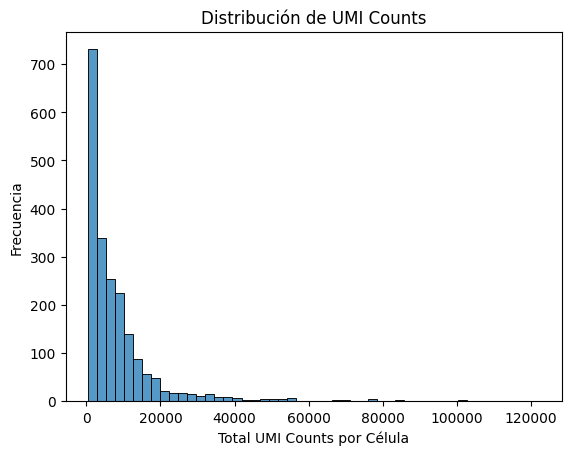

count      2049.000000
mean       8418.678711
std       11603.923828
min         500.000000
25%        1869.000000
50%        4957.000000
75%       10058.000000
max      122184.000000
Name: total_counts, dtype: float64


In [9]:
# Histograma de total_counts
sns.histplot(adata.obs['total_counts'], bins=50, kde=False)
plt.xlabel('Total UMI Counts por Célula')
plt.ylabel('Frecuencia')
plt.title('Distribución de UMI Counts')
plt.show()

# Estadísticos descriptivos de los UMI counts
print(adata.obs['total_counts'].describe())

Filtros recomendados:

Filtro por UMI Counts Totales (expresión mínima y máxima):

- Mínimo: 500 UMI
- Máximo: 50.000 UMI, simil HPV16, pero aquí el criterio es más visual. se elimina hasta ese valor ya que luego los valores existentes son muy escasos

Limite inferior sugerido en forma estandar por: https://www.10xgenomics.com/analysis-guides/common-considerations-for-quality-control-filters-for-single-cell-rna-seq-data

In [10]:
# Filtrar células por UMI counts
min_umi = 500
max_umi = 50000

adata = adata[(adata.obs['total_counts'] >= min_umi) & (adata.obs['total_counts'] <= max_umi), :]


# Confirmar el número de células después del filtro
print(f"Número de células después del filtro de UMI counts: {adata.n_obs}")

Número de células después del filtro de UMI counts: 2013


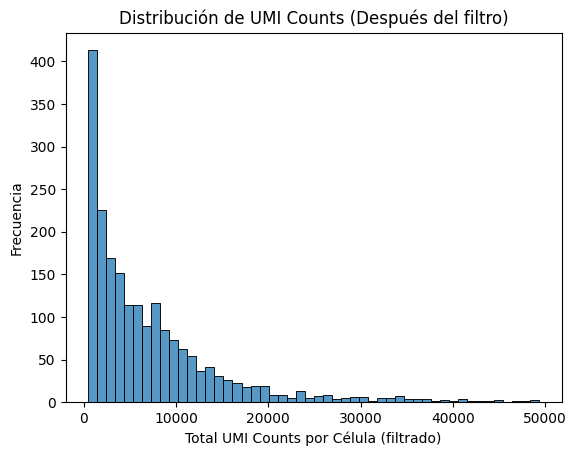

In [11]:
sns.histplot(adata.obs['total_counts'], bins=50, kde=False)
plt.xlabel('Total UMI Counts por Célula (filtrado)')
plt.ylabel('Frecuencia')
plt.title('Distribución de UMI Counts (Después del filtro)')
plt.show()

## 2. Distribución del número de genes detectados / Frecuencia

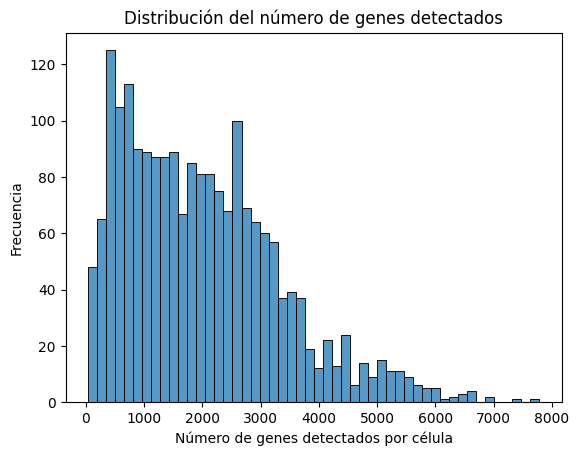

count    2013.000000
mean     2000.767511
std      1342.607281
min        40.000000
25%       891.000000
50%      1818.000000
75%      2788.000000
max      7781.000000
Name: n_genes_by_counts, dtype: float64


In [12]:
# Histograma del número de genes detectados por célula
sns.histplot(adata.obs['n_genes_by_counts'], bins=50, kde=False)
plt.xlabel('Número de genes detectados por célula')
plt.ylabel('Frecuencia')
plt.title('Distribución del número de genes detectados')
plt.show()

# Estadísticos descriptivos
print(adata.obs['n_genes_by_counts'].describe())

#### La mayoría de las células tienen entre 500 y 4,00 genes detectados, lo cual es típico.
Hay una "cola corta" hacia valores más altos (>5,000 genes), lo que podría indicar dobletes.
En el lado bajo (<500 genes), parece haber células con pocos genes detectados que podrían ser gotas vacías o ruido técnico.

Mínimo: 40 genes (claramente ruido técnico o gotas vacías).
Media: 2,000 genes.
Desviación estándar: 1,342 genes.
Percentil 25 (Q1): 891 genes (límite inferior inicial sugerido).
Percentil 75 (Q3): 2,788 genes (límite superior razonable, con margen).

- Mínimo de 500 genes (descarta células con menos de 500 genes, lo cual incluye ruido técnico).


- Máximo no se aplicarán filtros ya que la cola que existe es bastante corta


In [13]:
# Filtrar células por número de genes detectados
min_genes = 200
#max_genes = 6000 No se elimina limite superior 
adata = adata[(adata.obs['n_genes_by_counts'] >= min_genes), :]


# Confirmar el número de células después del filtro
print(f"Número de células después del filtro de genes detectados: {adata.n_obs}")

Número de células después del filtro de genes detectados: 1964


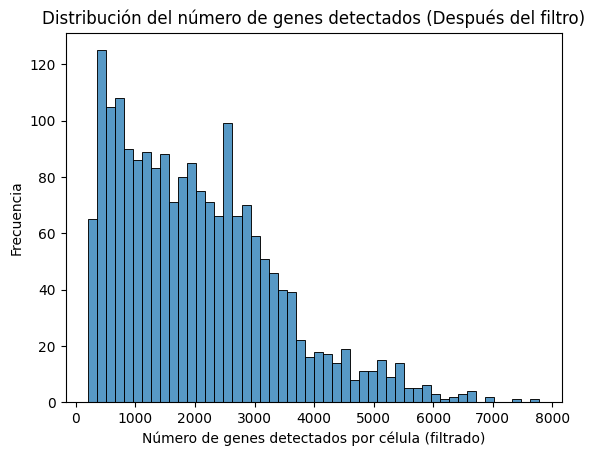

count    1964.000000
mean     2047.845723
std      1325.305644
min       206.000000
25%       956.500000
50%      1854.000000
75%      2824.000000
max      7781.000000
Name: n_genes_by_counts, dtype: float64


In [14]:
sns.histplot(adata.obs['n_genes_by_counts'], bins=50, kde=False)
plt.xlabel('Número de genes detectados por célula (filtrado)')
plt.ylabel('Frecuencia')
plt.title('Distribución del número de genes detectados (Después del filtro)')
plt.show()

print(adata.obs['n_genes_by_counts'].describe())

## 3. Porcentaje de genes mitocondriales por célula/frecuencia

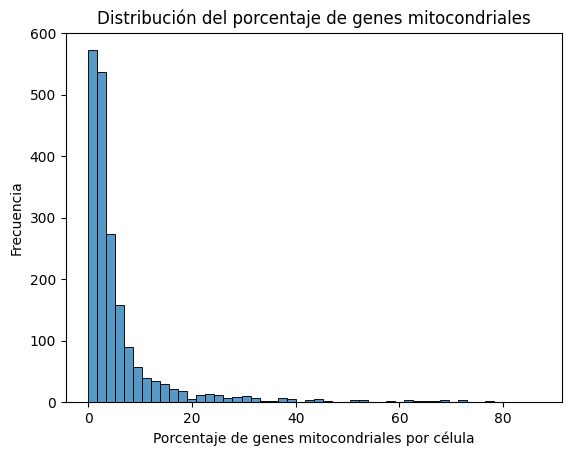

count    1964.000000
mean        6.281646
std        10.298586
min         0.000000
25%         1.519390
50%         2.986126
75%         5.999223
max        86.950401
Name: pct_counts_mt, dtype: float64


In [15]:
# Histograma de porcentaje de lecturas mitocondriales
sns.histplot(adata.obs['pct_counts_mt'], bins=50, kde=False)
plt.xlabel('Porcentaje de genes mitocondriales por célula')
plt.ylabel('Frecuencia')
plt.title('Distribución del porcentaje de genes mitocondriales')
plt.show()

# Estadísticos descriptivos
print(adata.obs['pct_counts_mt'].describe())

Criterios comunes para el filtrado de lecturas mitocondriales

Células con bajo porcentaje de genes mitocondriales:
Representan células saludables y activas con ARN de alta calidad.
Células con alto porcentaje de genes mitocondriales:
Indicativo de daño celular, apoptosis, o artefactos.
Un umbral común es entre 5%-10% de genes mitocondriales.

Sin embargo, estos umbrales pueden ajustarse según el tipo de tejido:

En tejidos como el cerebro, es normal observar valores más altos (>10%) debido a la alta actividad metabólica.

Si bien no hay una gran cantidad de celulas con genes mitocondriales, se aplica el mismo filtro que en HPV16, con un max_mito de 30

In [16]:
# Filtrar células por porcentaje de genes mitocondriales
max_mito = 30

adata = adata[adata.obs['pct_counts_mt'] < max_mito, :]

# Confirmar el número de células restantes
print(f"Número de células después del filtro mitocondrial: {adata.n_obs}")

Número de células después del filtro mitocondrial: 1890


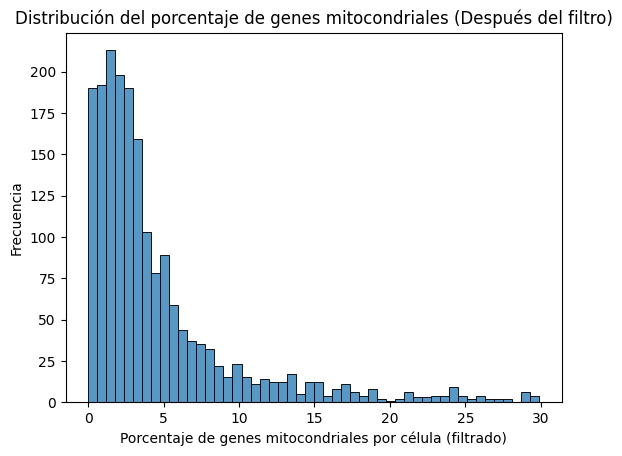

count    1890.000000
mean        4.615020
std         5.231477
min         0.000000
25%         1.450545
50%         2.844041
75%         5.466253
max        29.889297
Name: pct_counts_mt, dtype: float64


In [17]:
# Repetir el histograma después del filtro
sns.histplot(adata.obs['pct_counts_mt'], bins=50, kde=False)
plt.xlabel('Porcentaje de genes mitocondriales por célula (filtrado)')
plt.ylabel('Frecuencia')
plt.title('Distribución del porcentaje de genes mitocondriales (Después del filtro)')
plt.show()

# Estadísticos descriptivos después del filtro
print(adata.obs['pct_counts_mt'].describe())

Ahora el rango de porcentajes de genes mitocondriales va de 0.00772% a un máximo de 19.81%, confirmando que el filtro de 20% fue correctamente aplicado.
La mayor densidad se encuentra entre 2% y 6%, lo cual es típico de células de buena calidad en análisis de scRNA-seq.
El "tail" hacia porcentajes más altos (más de 15%) ha desaparecido, lo que indica que las células dañadas o apoptóticas fueron eliminadas.

## 4. Puntaje de dobletes/frecuencia

In [18]:
# Extraer la matriz de conteos crudos
counts_matrix = adata.X

# Iniciar Scrublet
scrub = scr.Scrublet(counts_matrix, expected_doublet_rate=0.1) 

# Detectar dobletes
doublet_scores, predicted_doublets = scrub.scrub_doublets()

# Guardar los resultados en adata
adata.obs['doublet_score'] = doublet_scores
adata.obs['predicted_doublet'] = predicted_doublets

# Visualizar los resultados básicos
print(adata.obs[['doublet_score', 'predicted_doublet']].head())

#### Articulos
#https://scanpy.readthedocs.io/en/stable/api/generated/scanpy.pl.scrublet_score_distribution.html
#https://kb.10xgenomics.com/hc/en-us/articles/360001378811-What-is-the-maximum-number-of-cells-that-can-be-profiled

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.40
Detected doublet rate = 1.0%
Estimated detectable doublet fraction = 16.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.0%
Elapsed time: 2.3 seconds
                    doublet_score  predicted_doublet
AAACCTGAGAATGTTG-1       0.092437              False
AAACGGGAGCCCAACC-1       0.062185              False
AAACGGGAGGTACTCT-1       0.069519              False
AAACGGGCACTCGACG-1       0.110588              False
AAACGGGCAGGGTATG-1       0.058824              False


/tmp/ipykernel_3043313/3508439073.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_score'] = doublet_scores


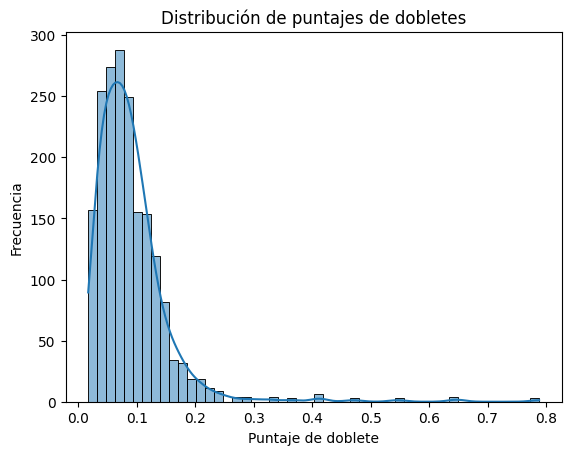

count    1890.000000
mean        0.090774
std         0.067786
min         0.016807
25%         0.052632
50%         0.077799
75%         0.110588
max         0.788235
Name: doublet_score, dtype: float64


predicted_doublet
False    1871
True       19
Name: count, dtype: int64

In [19]:
# Histograma de las puntuaciones de dobletes
sns.histplot(adata.obs['doublet_score'], bins=50, kde=True)
plt.xlabel('Puntaje de doblete')
plt.ylabel('Frecuencia')
plt.title('Distribución de puntajes de dobletes')
plt.show()

# Estadísticos descriptivos
print(adata.obs['doublet_score'].describe())

adata.obs['predicted_doublet'].value_counts()

In [20]:
# Filtrar células clasificadas como singletes
adata = adata[~adata.obs['predicted_doublet'], :]

# Verificar el tamaño del dataset después de eliminar dobletes
print(f"Datos después de eliminar dobletes: {adata.shape}")

Datos después de eliminar dobletes: (1871, 20615)


Después de eliminar los dobletes, ahora tenemos un total de 1871 células y 20,615 genes en el dataset. Esto indica que hemos finalizado la etapa de control de calidad (QC), incluyendo la eliminación de células de baja calidad, gotas vacías, células estresadas y dobletes.

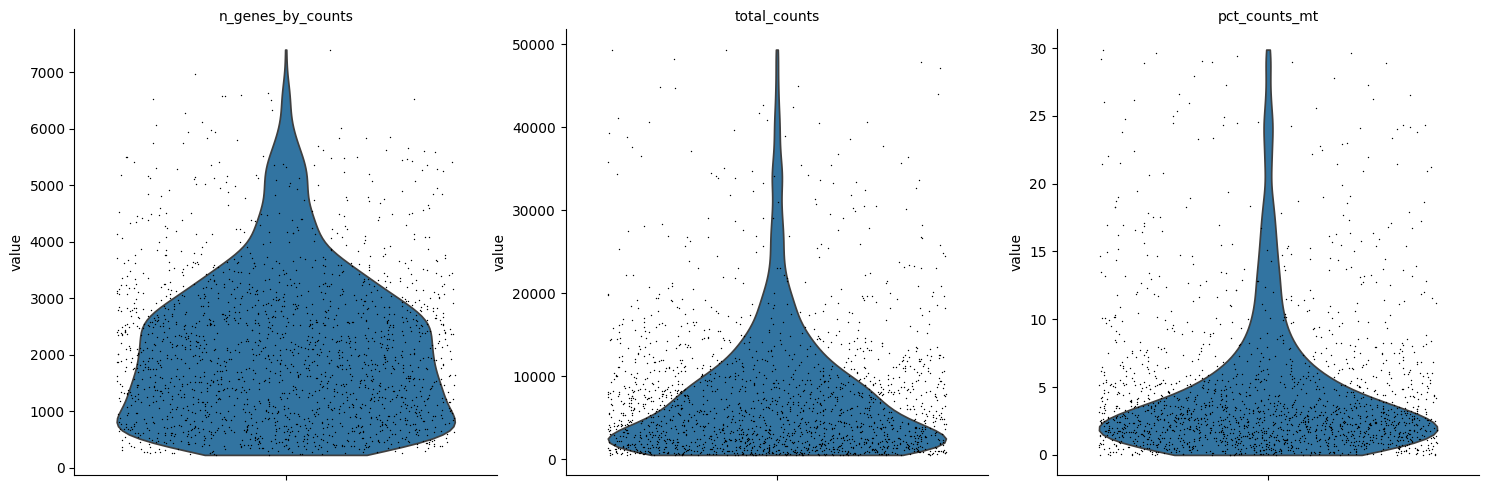

In [21]:
# Gráficos de violín para métricas clave
sc.pl.violin(
    adata,
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4,
    multi_panel=True
)

Gráfica n_genes_by_counts:

Rango de valores: 500 a más de 7,000 (consistente con los filtros aplicados previamente).
Distribución centralizada, lo que es típico para células de alta calidad.

Gráfica total_counts:

Rango de valores: 500-50,000 (también consistente con los filtros aplicados).
La distribución tiene una cola hacia valores más altos, pero no incluye valores extremos que podrían ser dobletes.

Gráfica pct_counts_mt:

Rango de valores: 0-30%.
La mayoría de las células tienen valores bajos (<10%), lo que indica que el filtrado fue eficaz en eliminar células estresadas, pero conservando un margen para células biológicamente relevantes.

In [22]:
sc.pp.calculate_qc_metrics(adata)

(                    n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
 AAACCTGAGAATGTTG-1               3440                 8.143517       12703.0   
 AAACGGGAGCCCAACC-1               1748                 7.466799        3380.0   
 AAACGGGAGGTACTCT-1               3104                 8.040769       12050.0   
 AAACGGGCACTCGACG-1               3365                 8.121480       13793.0   
 AAACGGGCAGGGTATG-1               5118                 8.540714       18786.0   
 ...                               ...                      ...           ...   
 TTTGGTTCATGCATGT-1                703                 6.556778        1504.0   
 TTTGGTTGTGATAAAC-1               2859                 7.958577       10569.0   
 TTTGGTTTCAGTTGAC-1                647                 6.473891        1100.0   
 TTTGTCAGTCTTTCAT-1                341                 5.834811         624.0   
 TTTGTCAGTGATAAAC-1                492                 6.200509         818.0   
 
                     log1p

In [23]:
filtered_adata=adata

In [24]:
# Normalizar los datos para que cada célula tenga una suma de 10,000 lecturas
sc.pp.normalize_total(filtered_adata, target_sum=1e4)

# Confirmar que los datos están normalizados
print("Datos normalizados. Cada célula ahora tiene una suma fija de lecturas.")

Datos normalizados. Cada célula ahora tiene una suma fija de lecturas.


/home/akim/Desktop/TFM/venv/tfm/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [25]:
# Escalar los datos para centrar los valores de cada gen en media 0 y varianza 1
sc.pp.log1p(filtered_adata)

In [26]:
print("Valor mínimo en la matriz de expresión:", np.min(filtered_adata.X))
print("Valor máximo en la matriz de expresión:", np.max(filtered_adata.X))

Valor mínimo en la matriz de expresión: 0.0
Valor máximo en la matriz de expresión: 9.029943


In [27]:
# Identificar genes altamente variables
sc.pp.highly_variable_genes(filtered_adata, flavor="seurat", n_top_genes=2000)

# Confirmar cuántos genes fueron seleccionados como altamente variables
print(f"{sum(filtered_adata.var['highly_variable'])} genes seleccionados como altamente variables.")

2000 genes seleccionados como altamente variables.


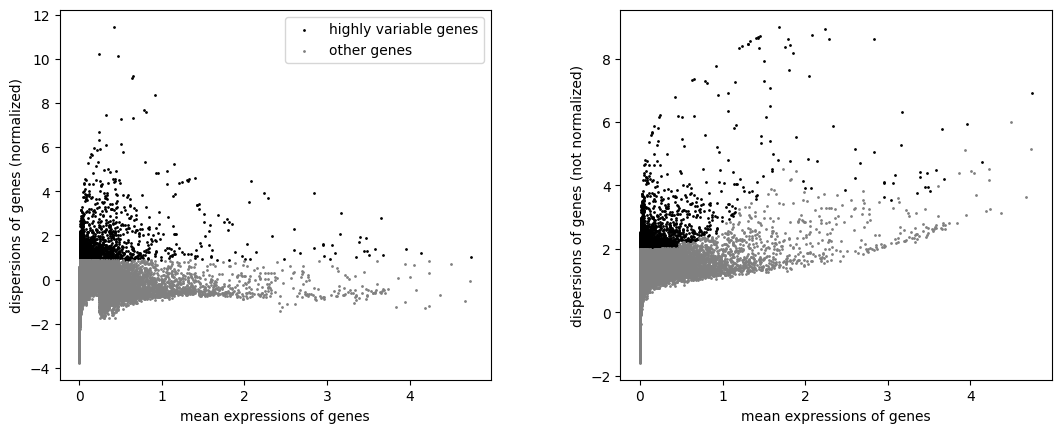

In [28]:
# Gráfico de genes altamente variables
sc.pl.highly_variable_genes(filtered_adata)

**Datos coherentes**

La selección de genes altamente variables parece adecuada y consistente con las características biológicas de los datos.

El escalado previamente aplicado no está afectando la selección de HVGs, ya que los datos sin escalado ahora se comportan como se espera.

**Genes informativos**

Los genes altamente variables seleccionados (negros) son los más relevantes para identificar diferencias entre tipos celulares o estados celulares en los pasos subsiguientes (PCA, clustering, etc.).

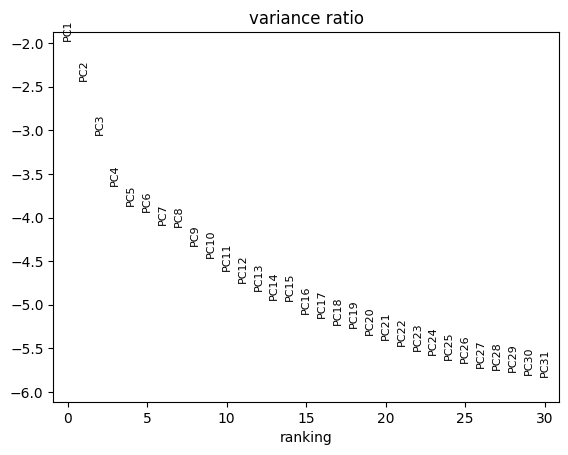

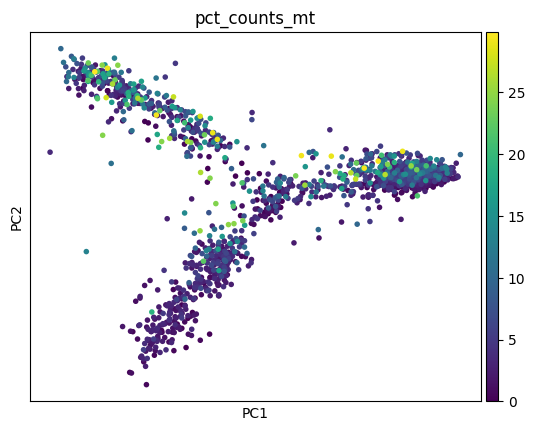

In [29]:
# Calcular PCA basado en los genes altamente variables
sc.tl.pca(filtered_adata, svd_solver='arpack')

# Visualizar la varianza explicada por cada componente principal
sc.pl.pca_variance_ratio(filtered_adata, log=True)

# Proyectar las células en los primeros dos componentes principales
sc.pl.pca(filtered_adata, color='pct_counts_mt')

In [30]:
## Copia de información antes de análisis para PCA y clusterización
adata_testing = filtered_adata.copy()

## Ahora debemos analizar cuales son los valores que se deben utilizar como n_pcs, n_neighbors y resolution.
- **`n_pcs`**: Define cuántos componentes principales (PCs) de la reducción de dimensionalidad por PCA se usarán para construir el gráfico de vecinos, afectando la calidad de la clusterización y la preservación de la variabilidad biológica.  
- **`n_neighbors`**: Controla cuántos vecinos cercanos se consideran en la construcción del gráfico de conectividad, influyendo en la detección de estructuras locales y la separación de clusters.  
- **`resolution`**: Ajusta el tamaño y número de clusters en algoritmos como Leiden, donde valores bajos generan menos clusters grandes y valores altos producen más clusters pequeños.

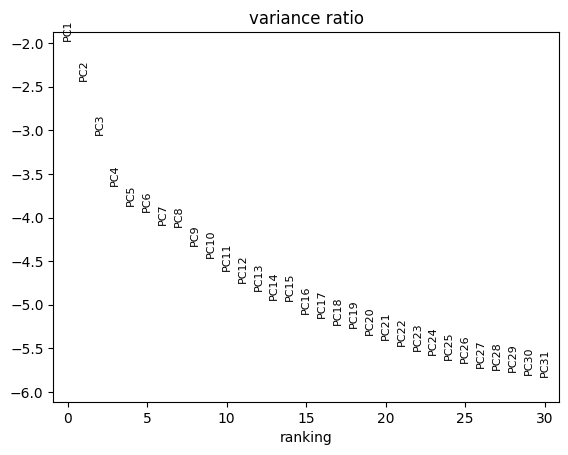

In [31]:
#Métodos para elegir n_pcs óptimo

sc.pl.pca_variance_ratio(adata_testing, log=True)

En los próximos gráficos se agregan los números de cluster por encima de la gráfica ya que al haber varios gráficos apilados a veces no aparecen todos

/home/akim/Desktop/TFM/venv/tfm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_3043313/1597341982.py:18: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_testing, resolution=res, random_state=42)


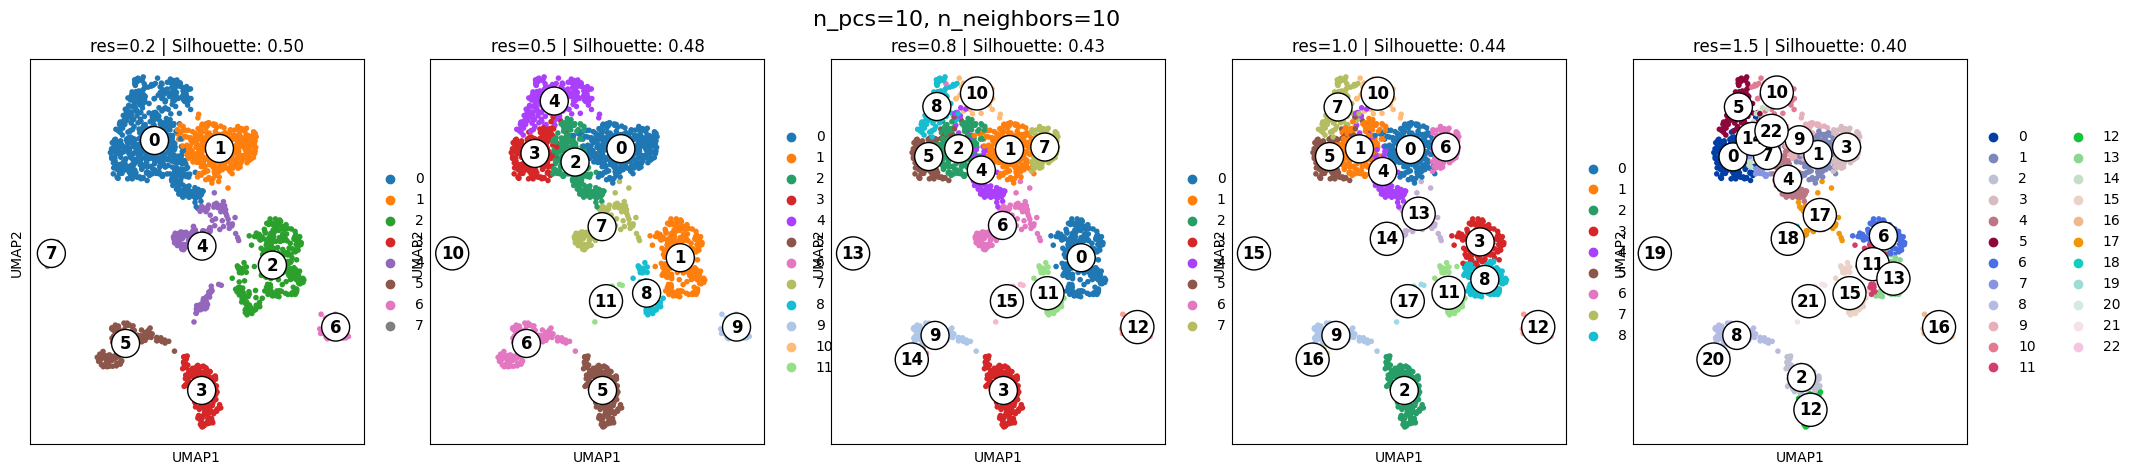

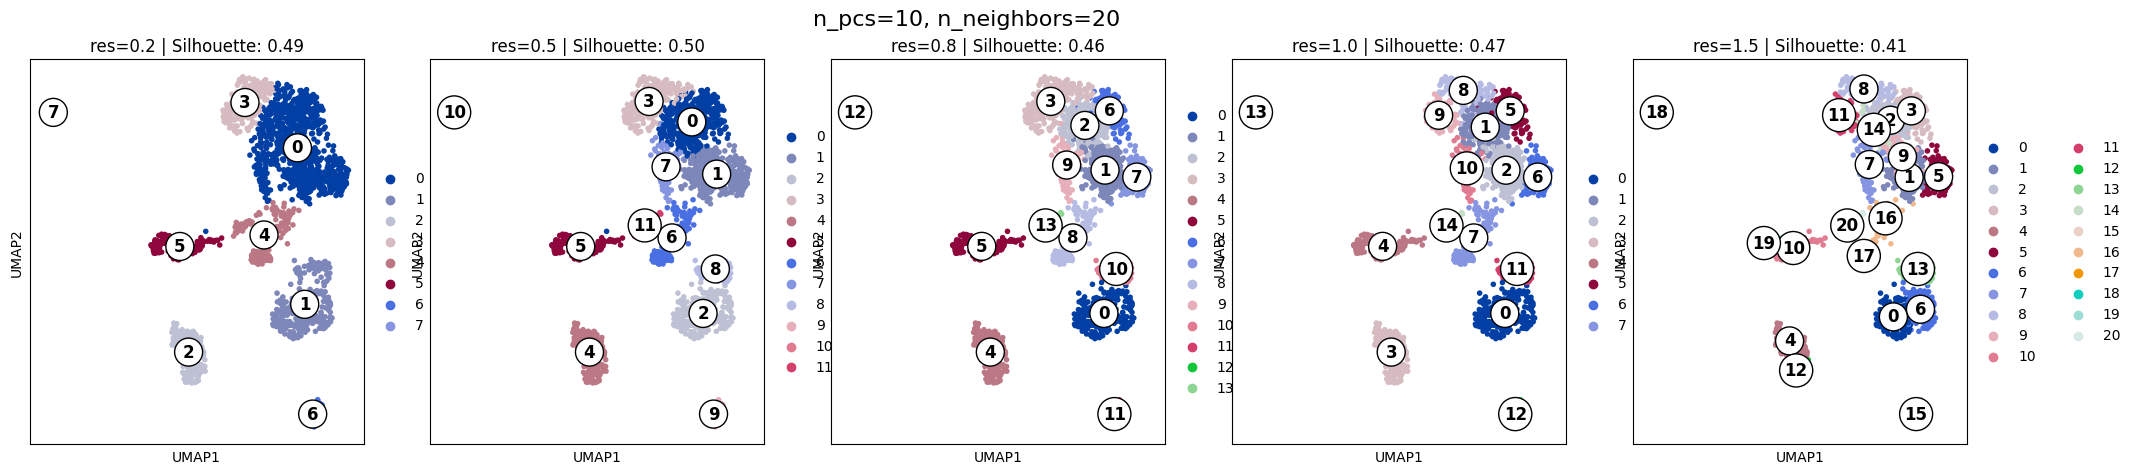

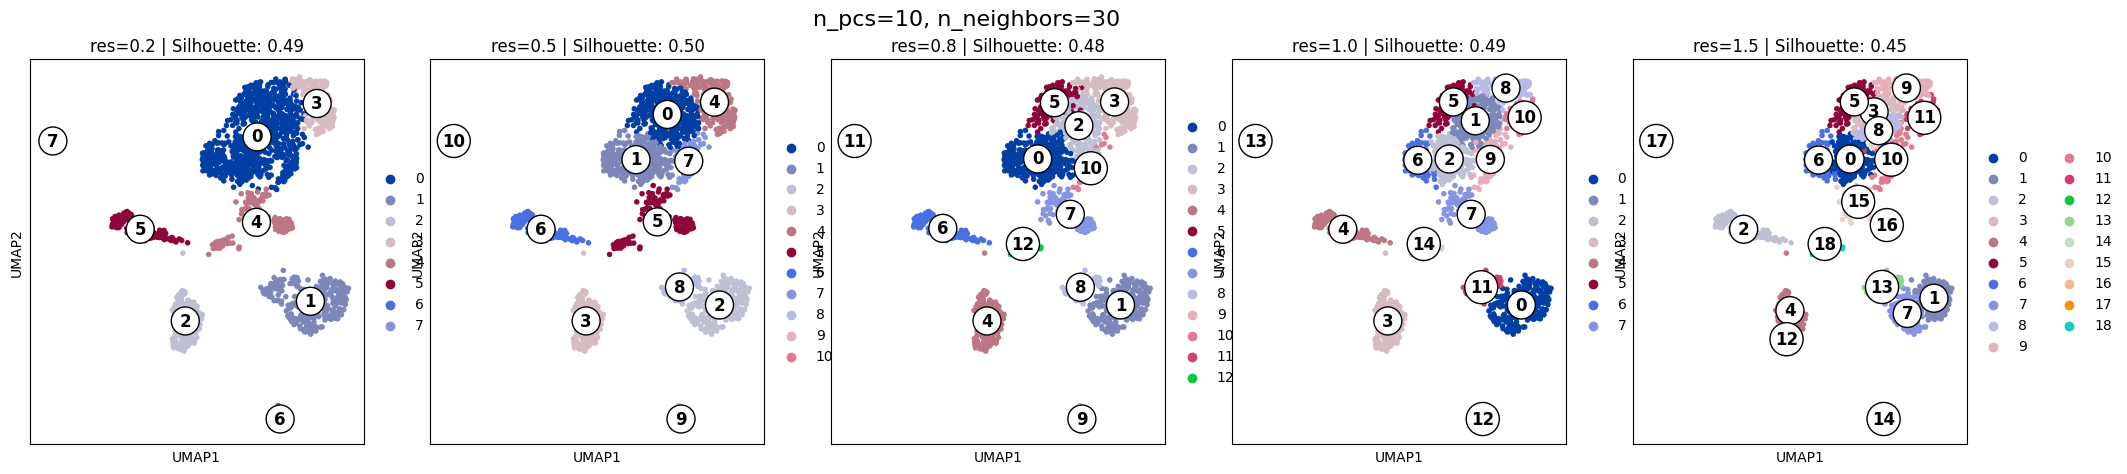

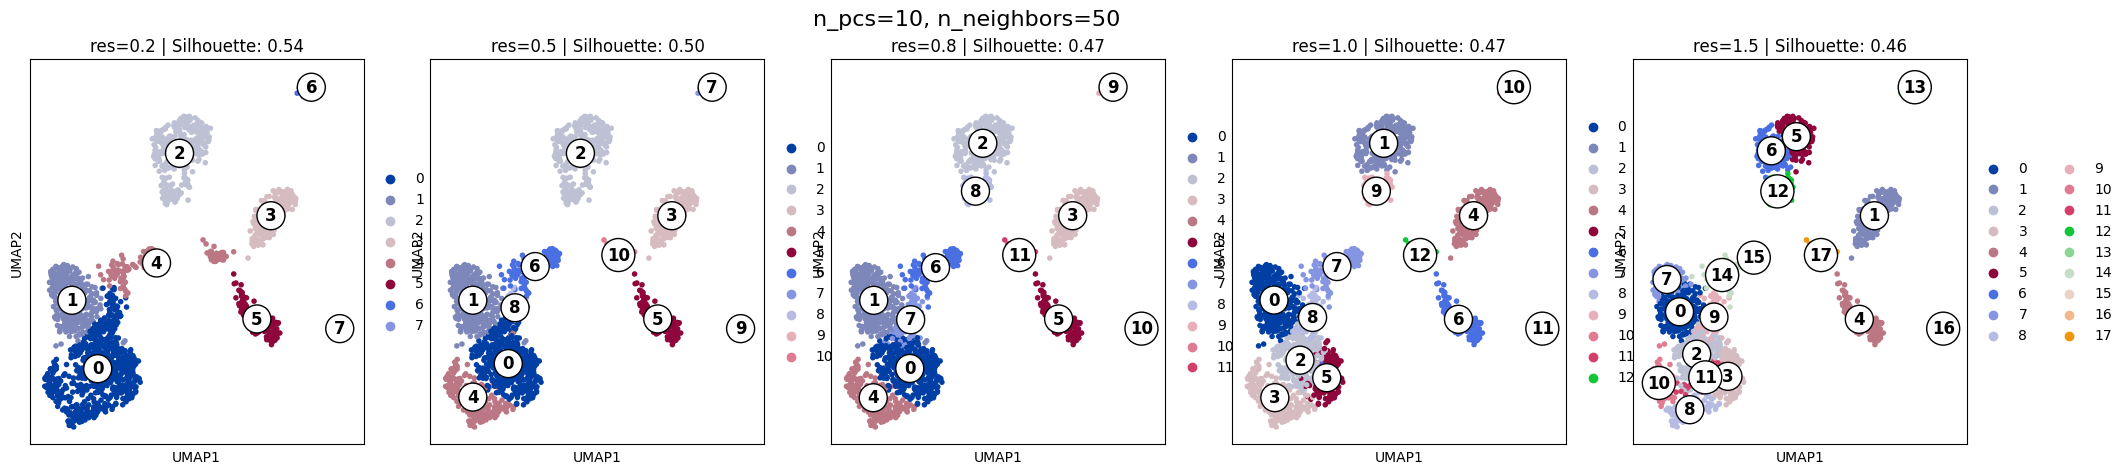

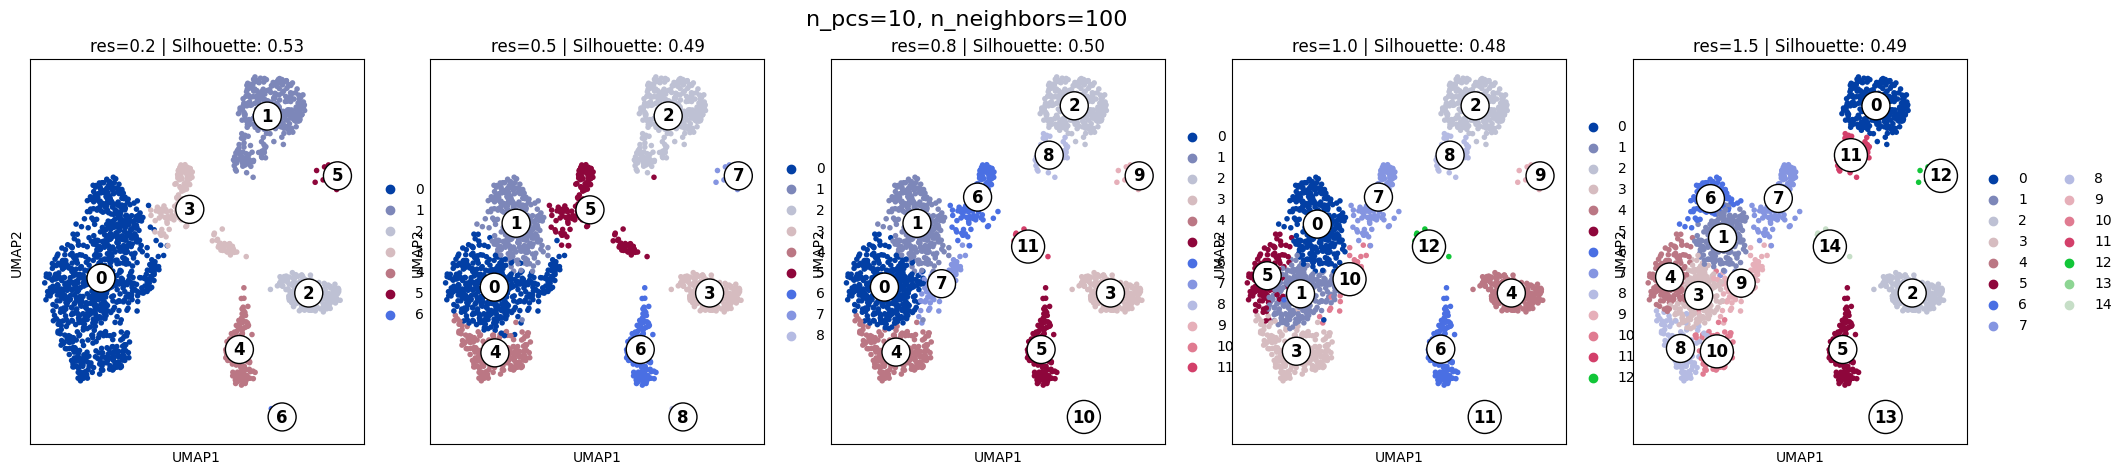

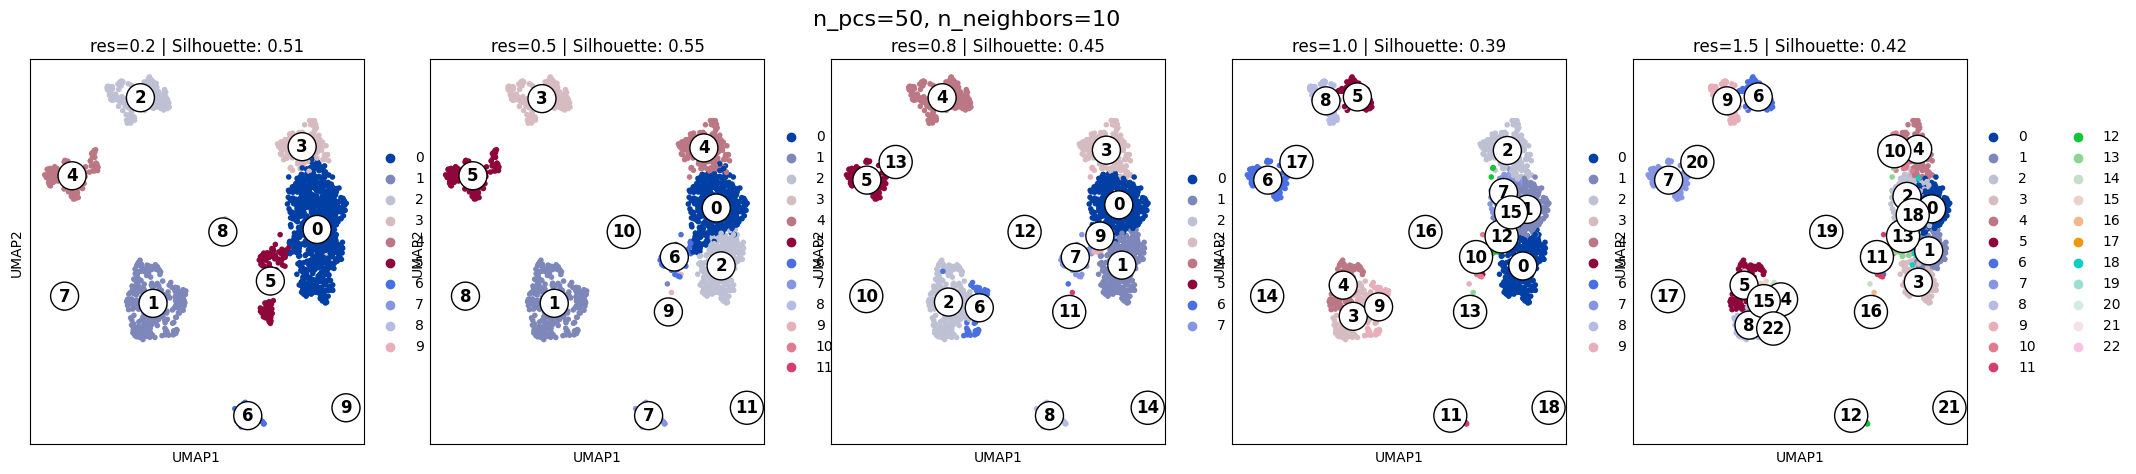

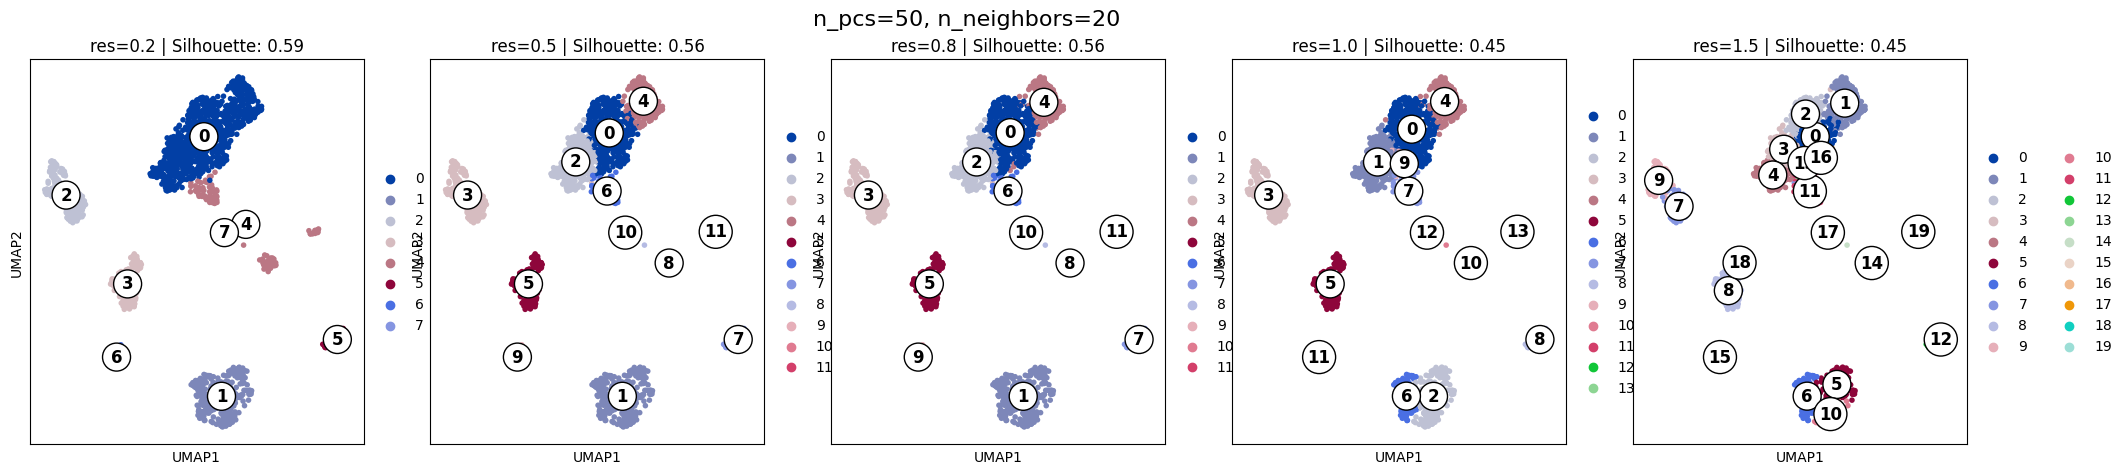

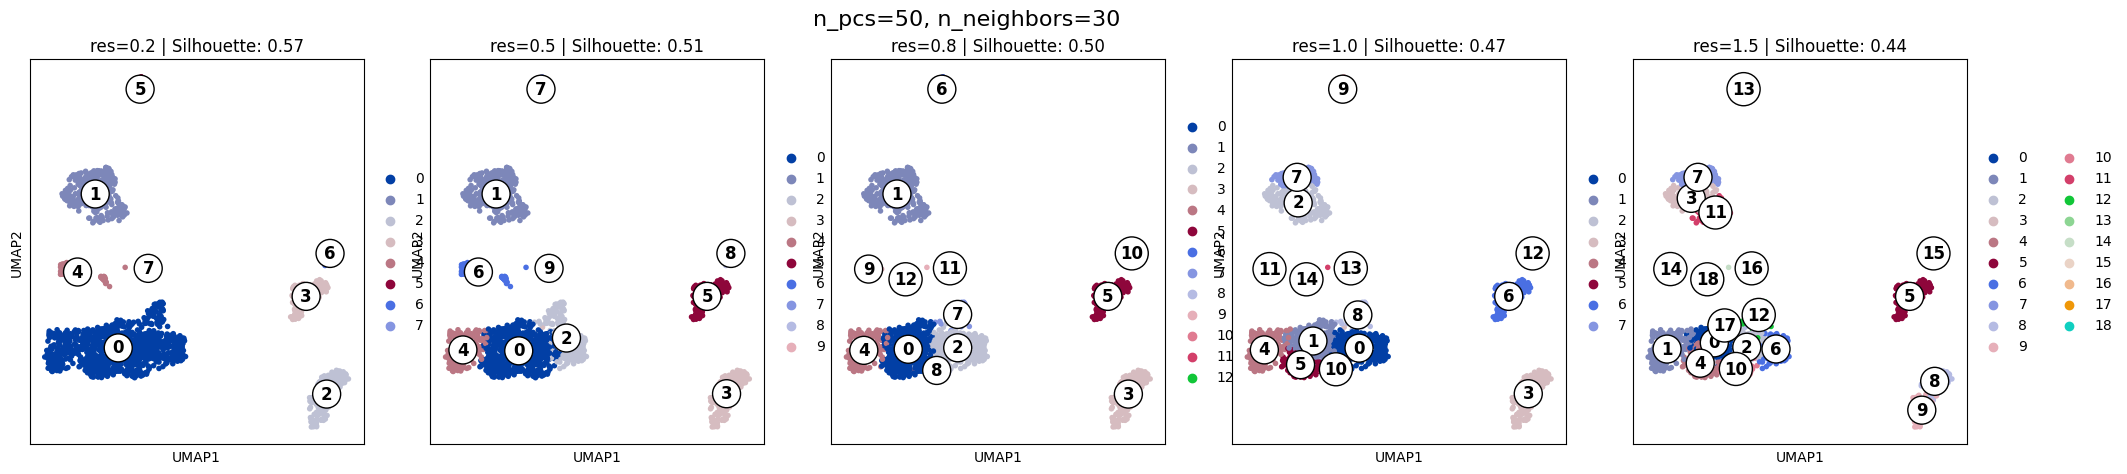

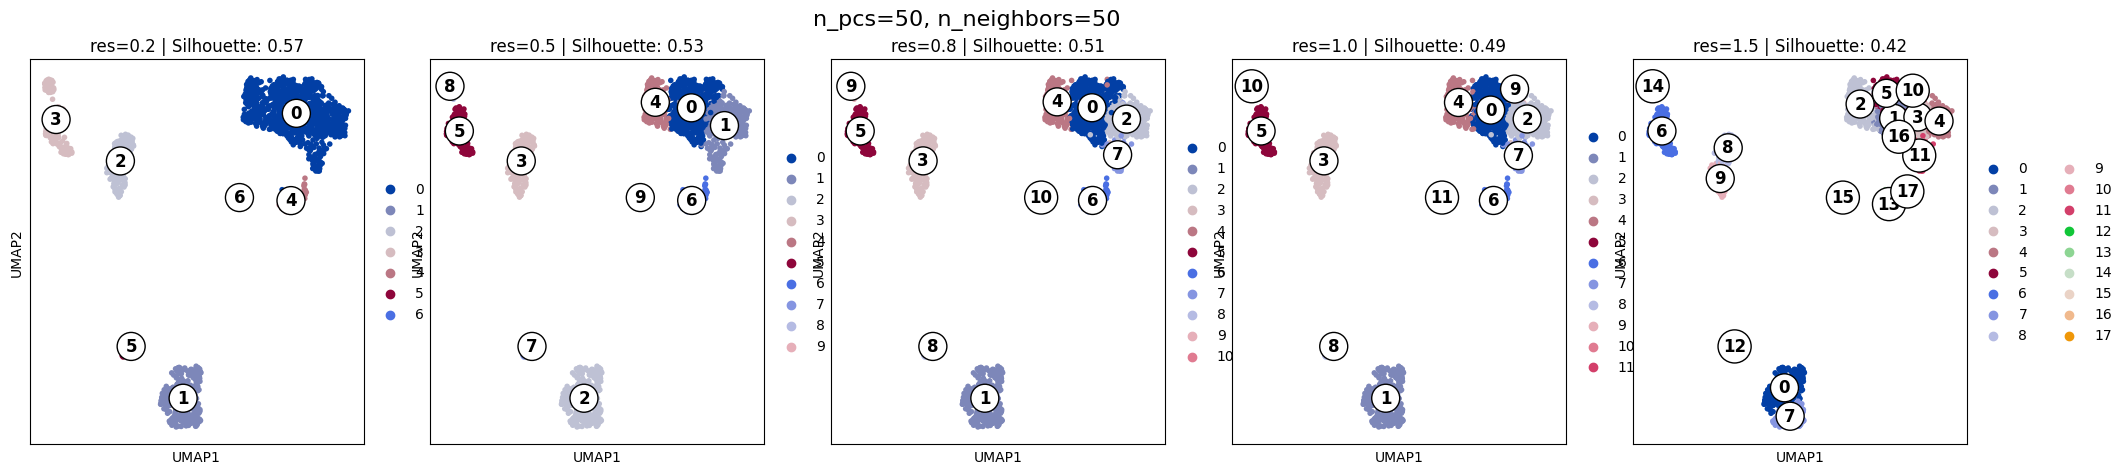

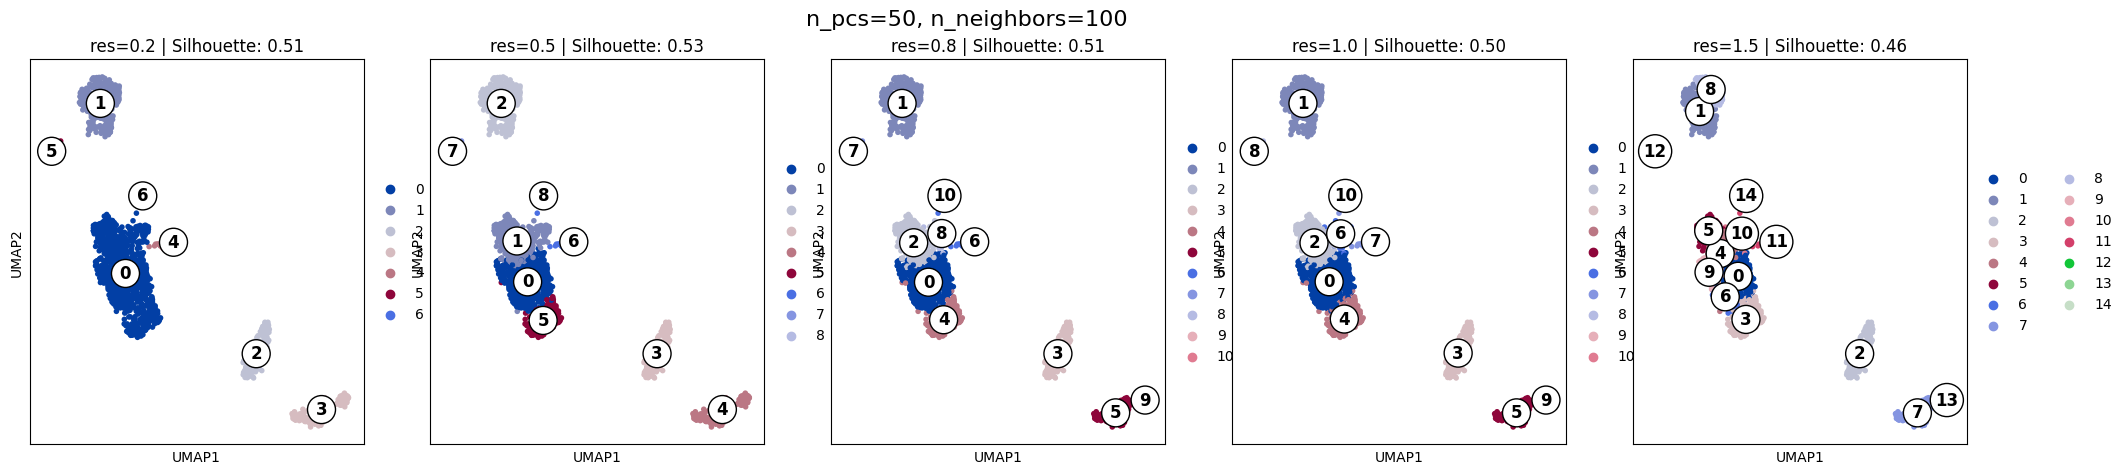

ValueError: `X_pca` does not have enough PCs. Rerun `sc.pp.pca` with adjusted `n_comps`.

In [32]:
# Listas de parámetros a explorar
n_pcs_list = [10, 50, 100]
n_neighbors_list = [10, 20, 30, 50, 100]
resolutions = [0.2, 0.5, 0.8, 1.0, 1.5]

# Iterar sobre todas las combinaciones posibles
for n_pcs, n_neighbors in itertools.product(n_pcs_list, n_neighbors_list):
    
    # Calcular vecinos con los parámetros actuales
    sc.pp.neighbors(adata_testing, n_pcs=n_pcs, n_neighbors=n_neighbors)
    
    # Crear una figura para cada combinación de n_pcs y n_neighbors
    fig, axes = plt.subplots(1, len(resolutions), figsize=(5 * len(resolutions), 5))
    fig.suptitle(f"n_pcs={n_pcs}, n_neighbors={n_neighbors}", fontsize=16)

    for i, res in enumerate(resolutions):
        # Aplicar Leiden clustering
        sc.tl.leiden(adata_testing, resolution=res, random_state=42)
        sc.tl.umap(adata_testing)

        # Calcular el Silhouette Score
        labels = adata_testing.obs['leiden'].astype(int)  # Convertir a entero para evitar errores
        embeddings = adata_testing.obsm['X_umap']
        if len(set(labels)) > 1:  # Evitar errores si solo hay un cluster
            silhouette_avg = silhouette_score(embeddings, labels)
        else:
            silhouette_avg = -1  # Si solo hay un cluster, no tiene sentido calcularlo

        # Graficar UMAP
        sc.pl.umap(adata_testing, color='leiden', 
                   title=f"res={res} | Silhouette: {silhouette_avg:.2f}", 
                   ax=axes[i], show=False)

        # Calcular centroides de los clusters para anotarlos en el gráfico
        cluster_centroids = {}
        for cluster in set(labels):
            mask = labels == cluster
            cluster_centroids[cluster] = np.mean(embeddings[mask], axis=0)

        # Añadir etiquetas de cluster en el gráfico
        for cluster, (x, y) in cluster_centroids.items():
            axes[i].text(x, y, str(cluster), fontsize=12, weight='bold', 
                         color='black', ha='center', va='center', 
                         bbox=dict(facecolor='white', edgecolor='black', boxstyle='circle,pad=0.3'))

    # Mostrar los gráficos de esta configuración
    plt.show()

## Observaciones:
- Se puede observar que una resolución mayor a 0.8 agrega ruido al análisis unicamente como también lleva al análisis a una sobreclusterización
- No hay valores suficientes como para hacer un análisis n_pcs=100
- Mayor es el n_neighbors puede contribuir a un mejor análisis pero puede generar ruido

## Afinamos un poco más el análisis.

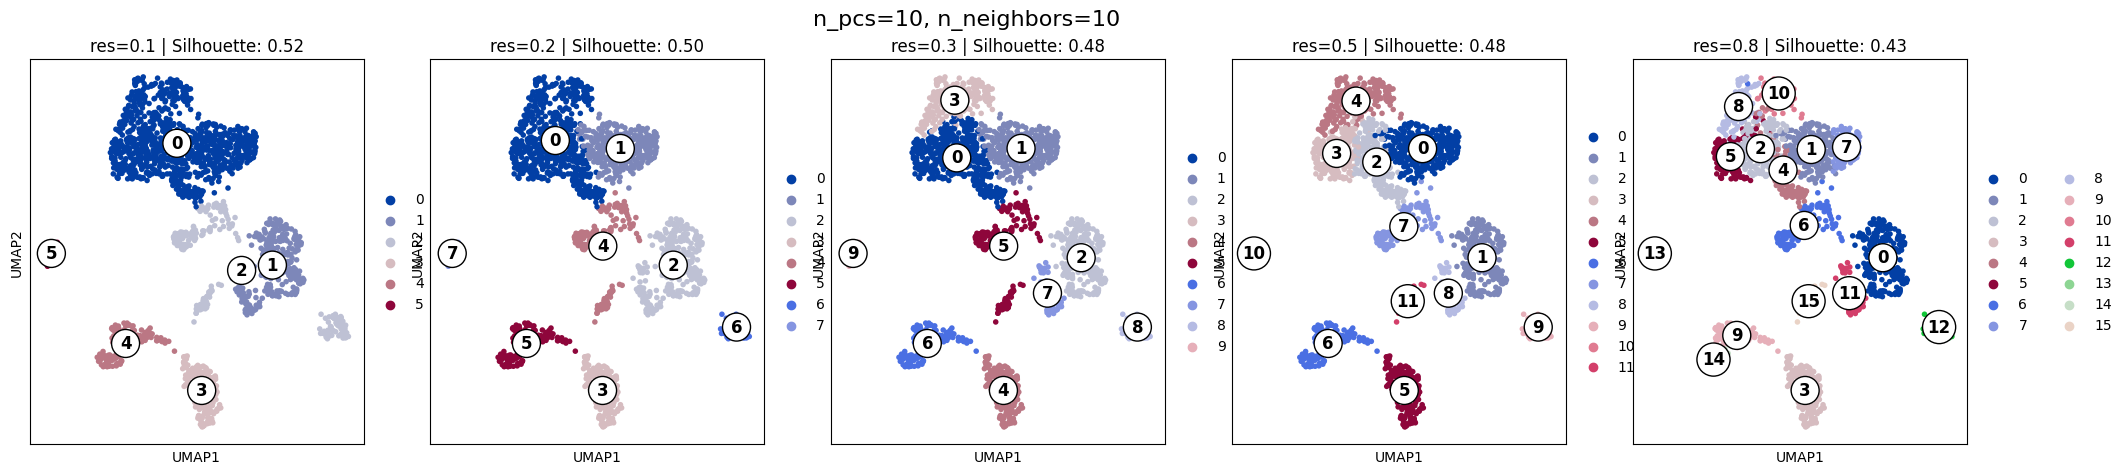

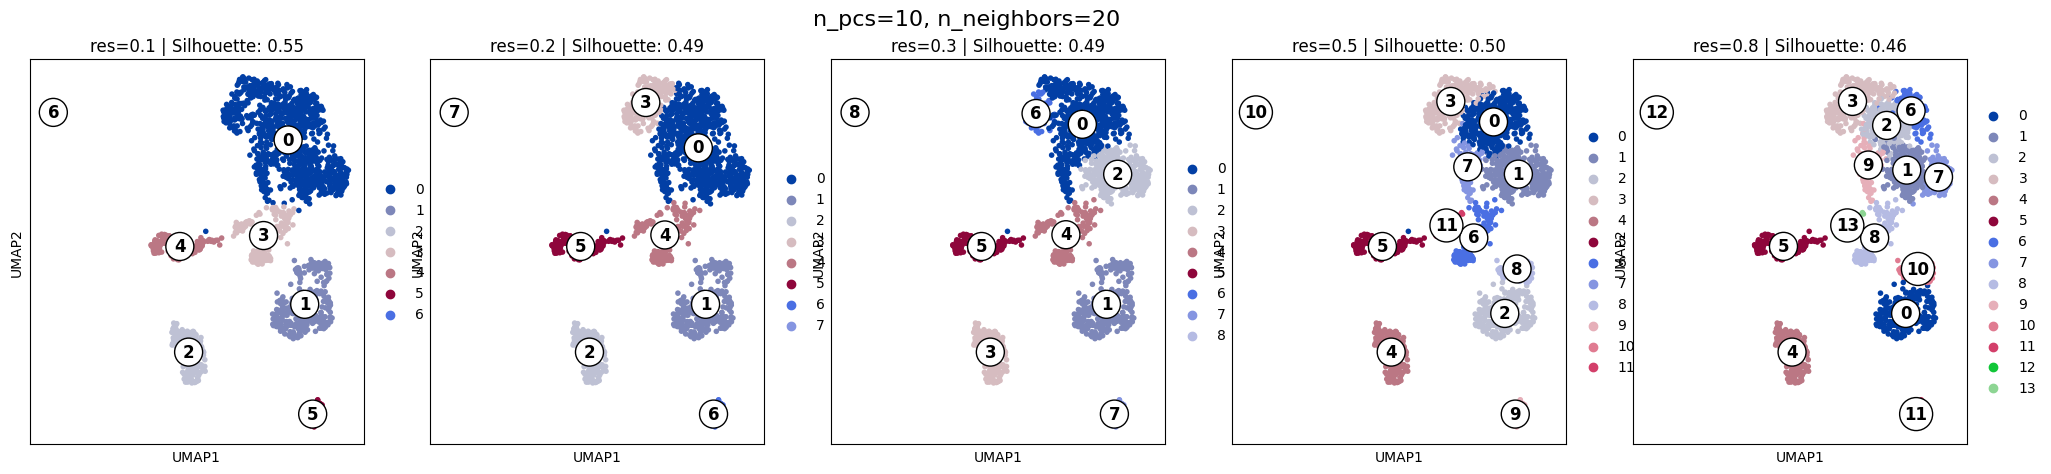

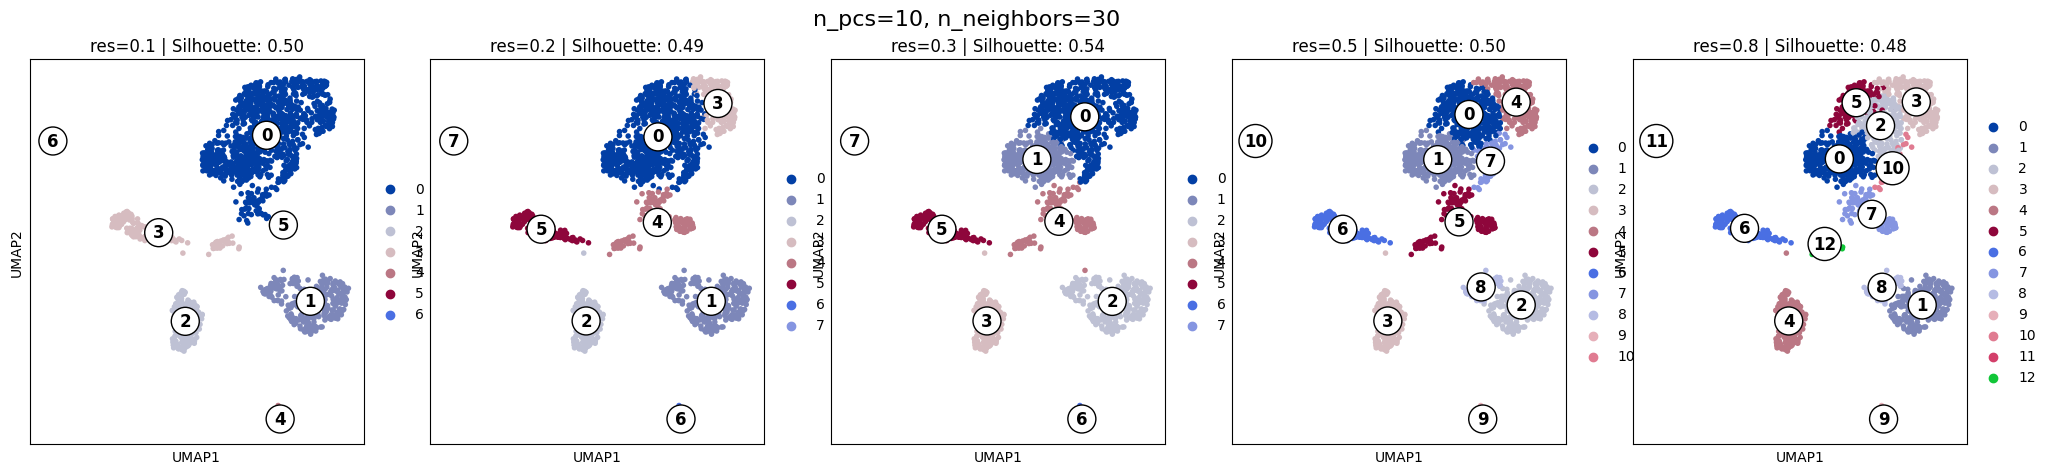

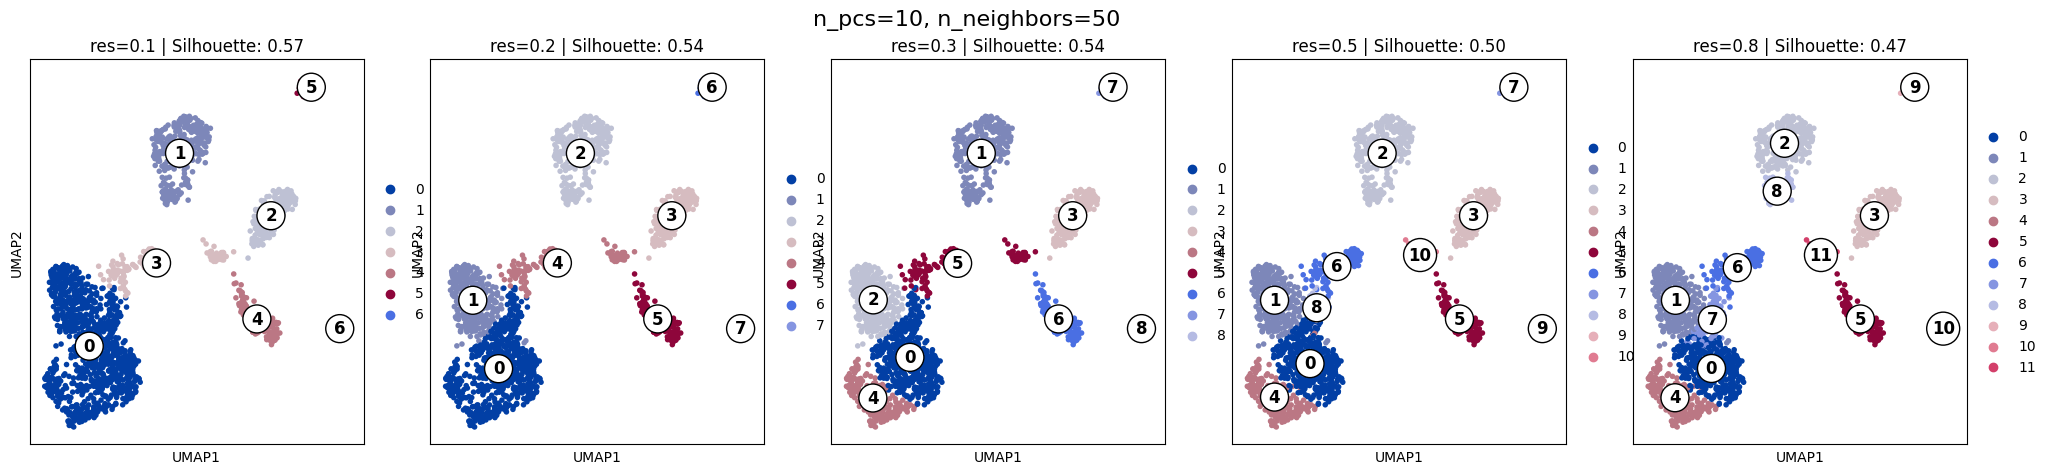

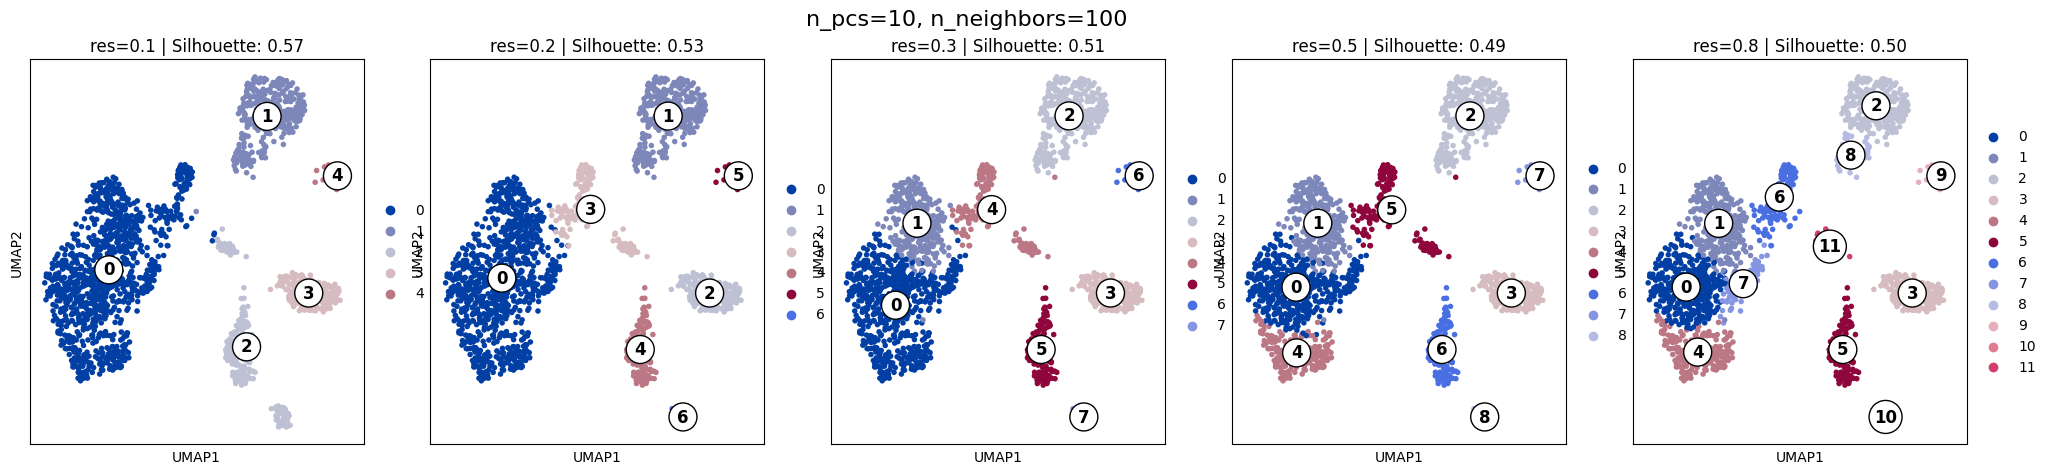

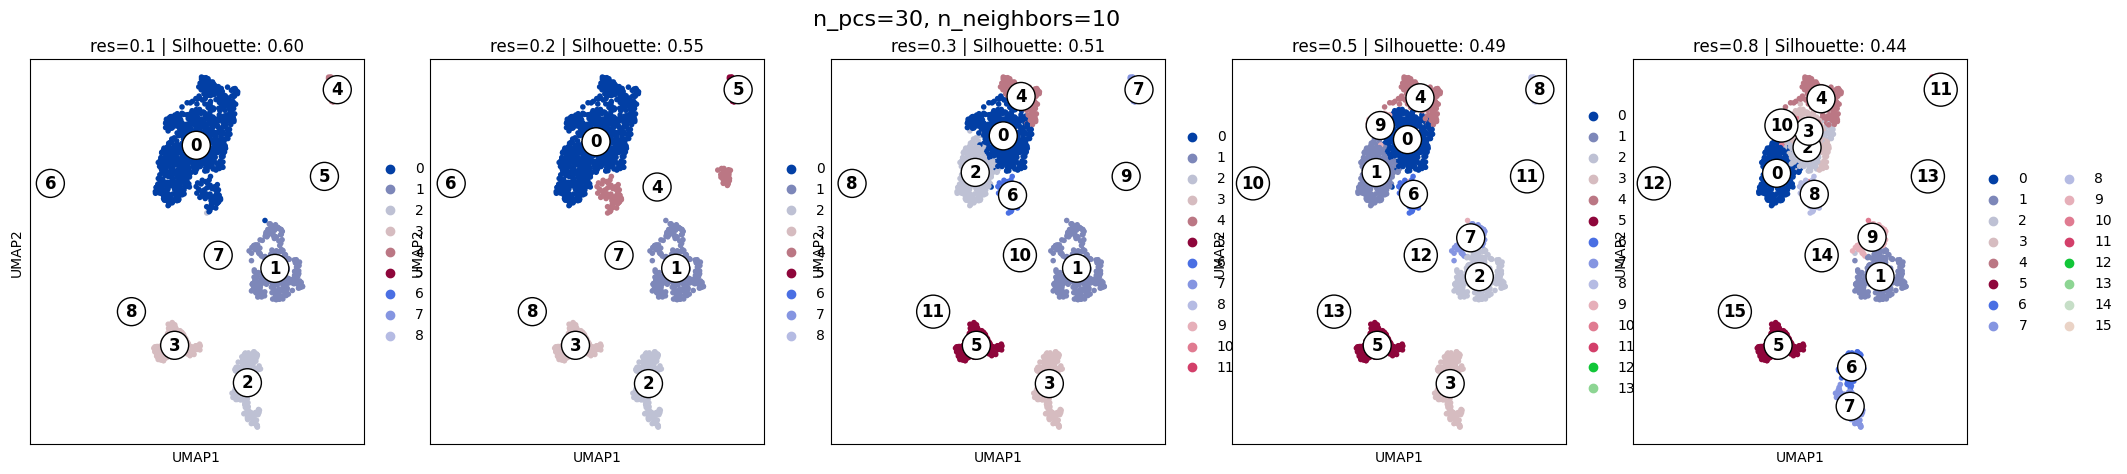

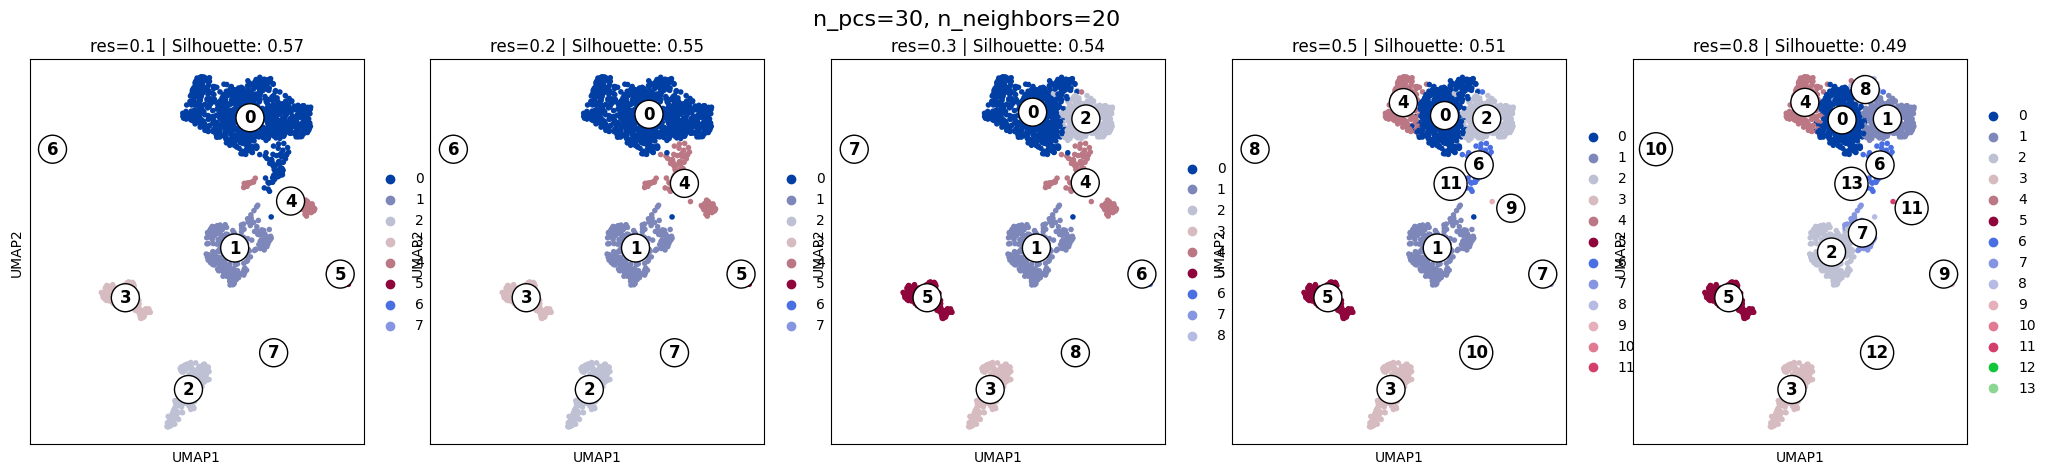

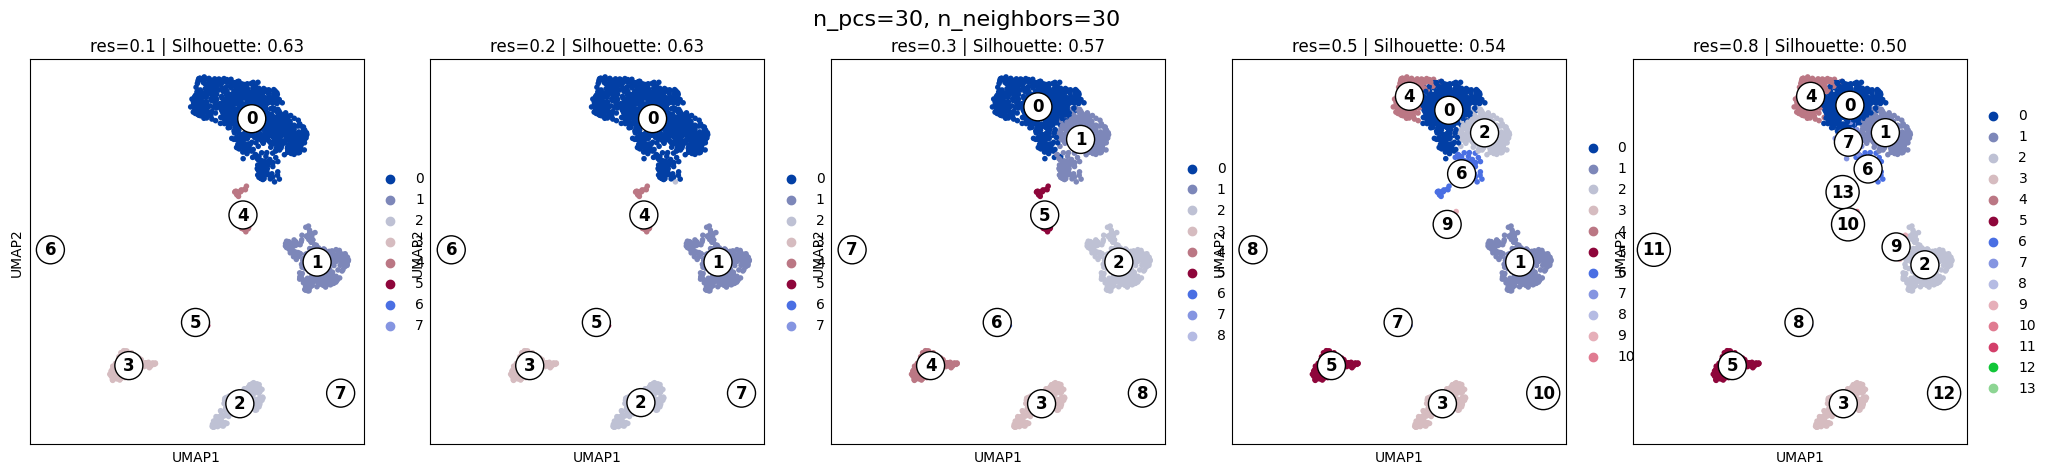

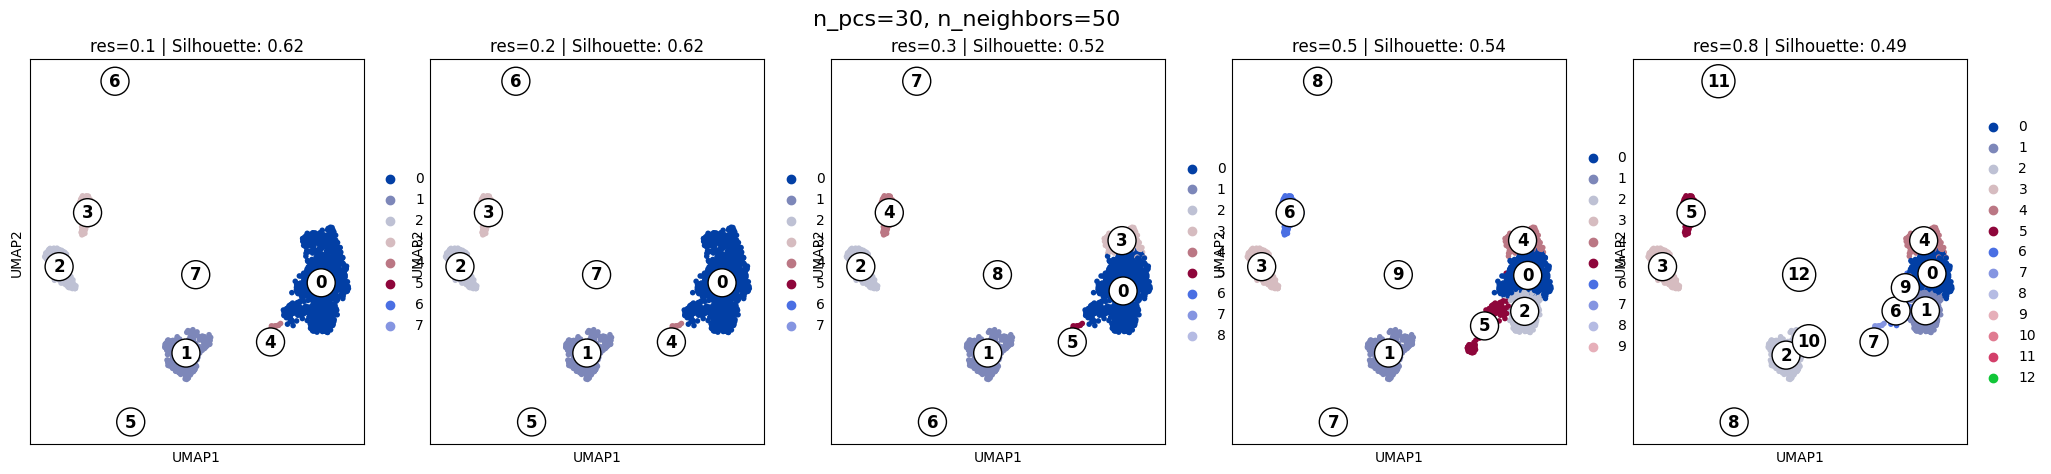

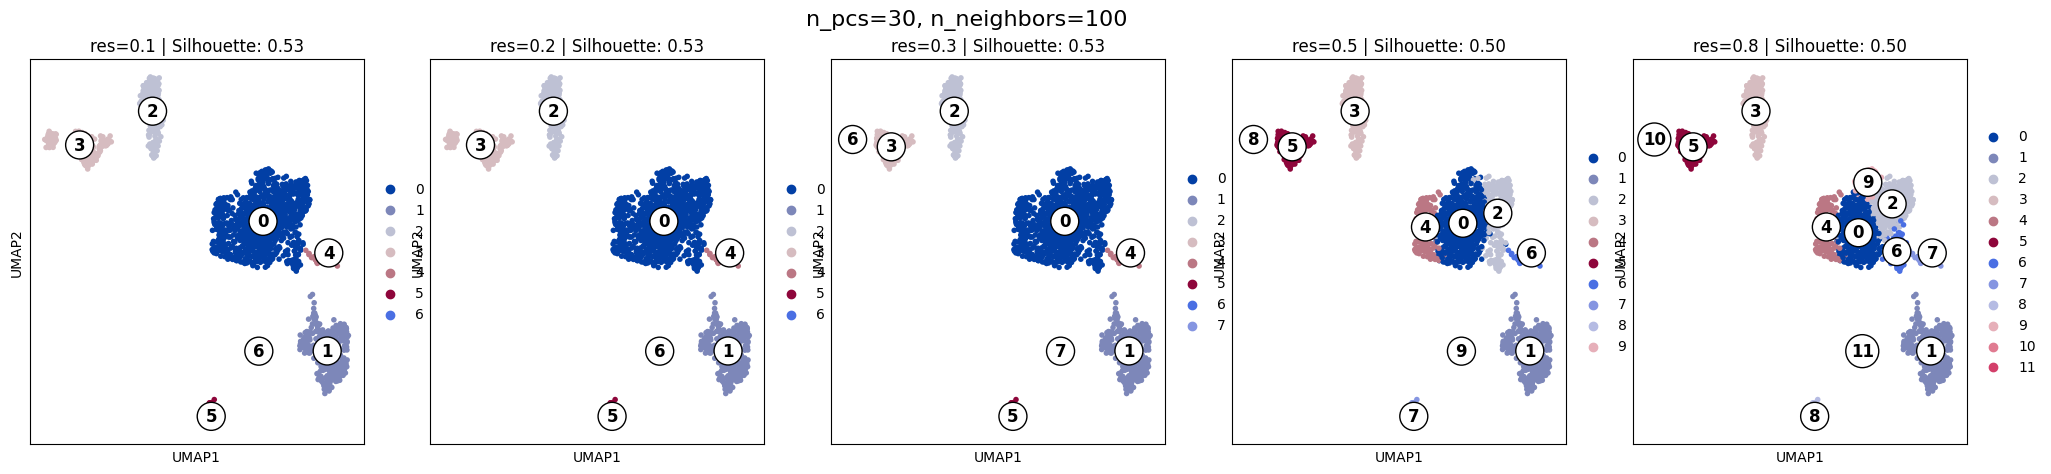

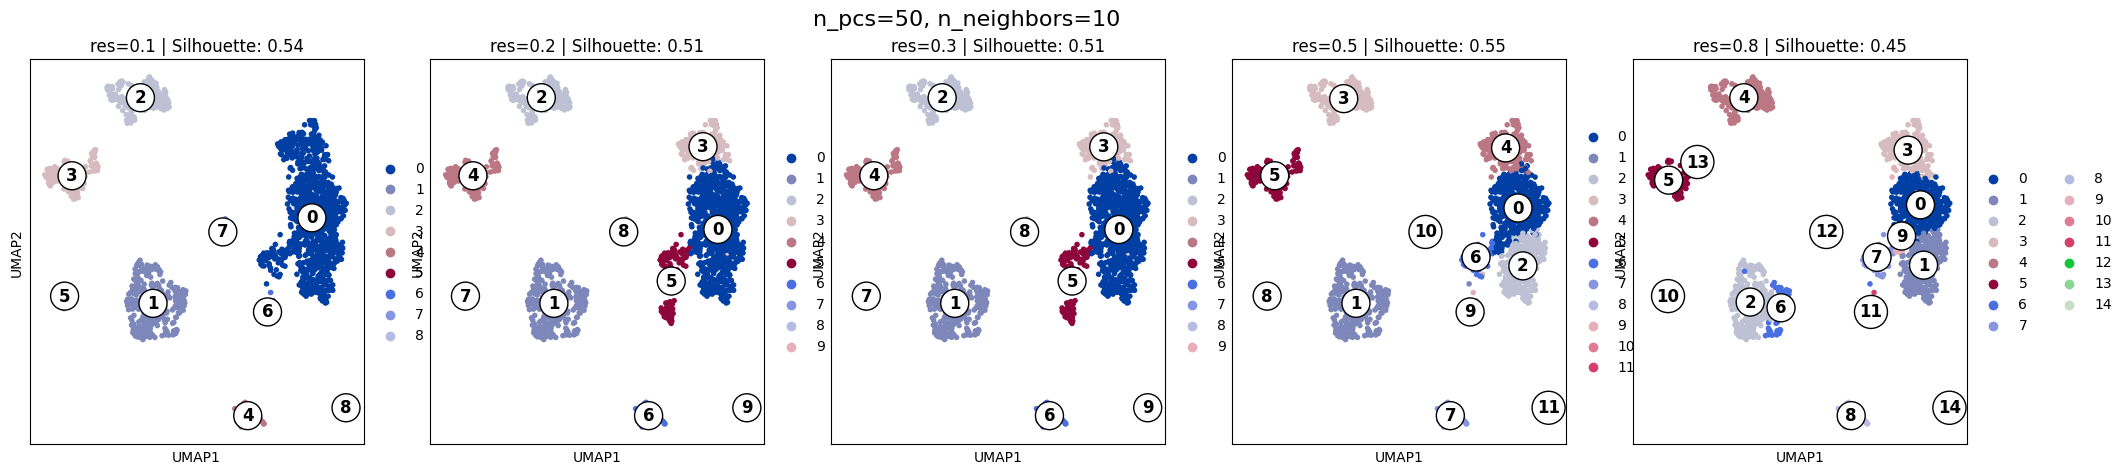

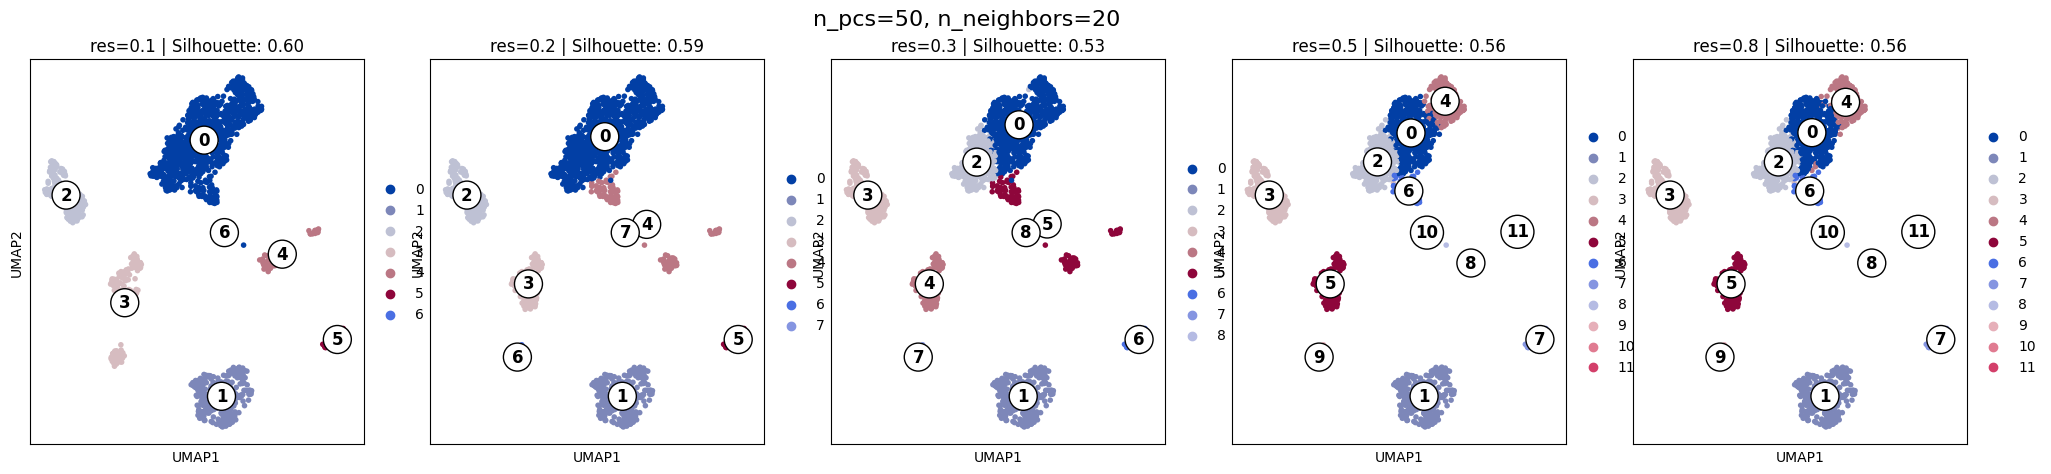

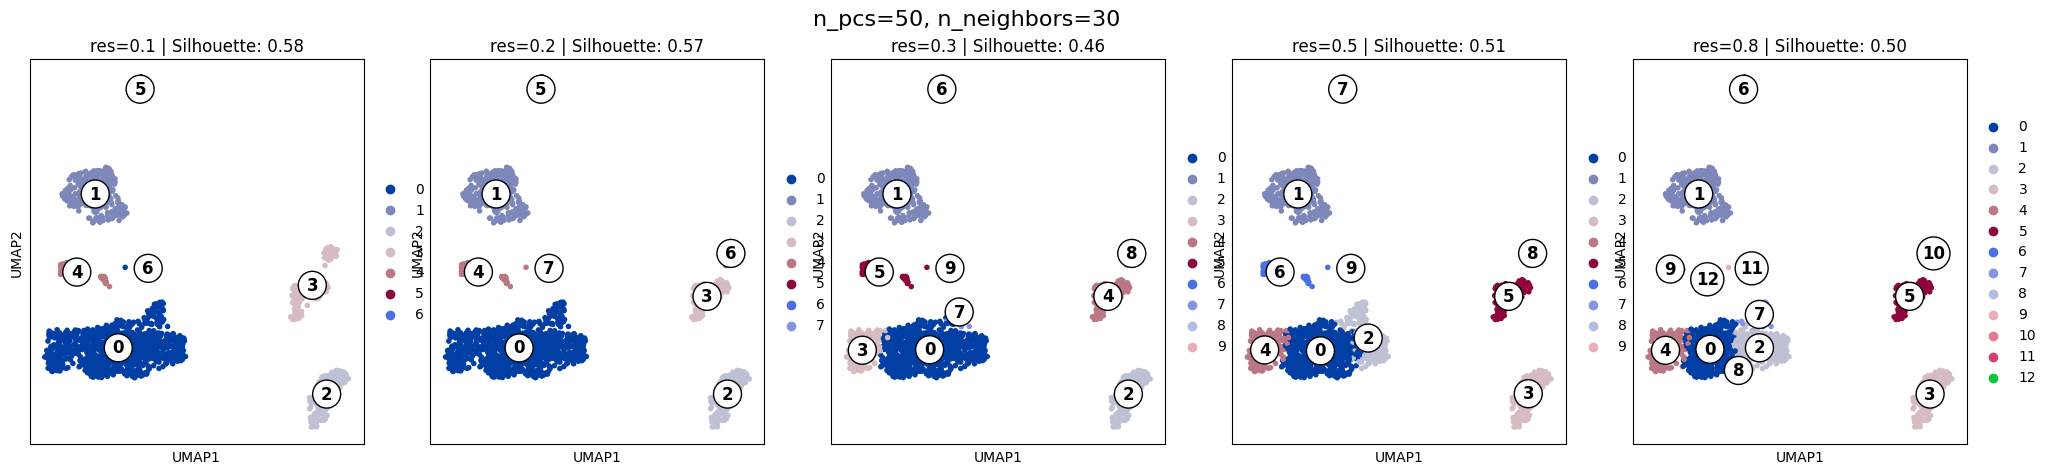

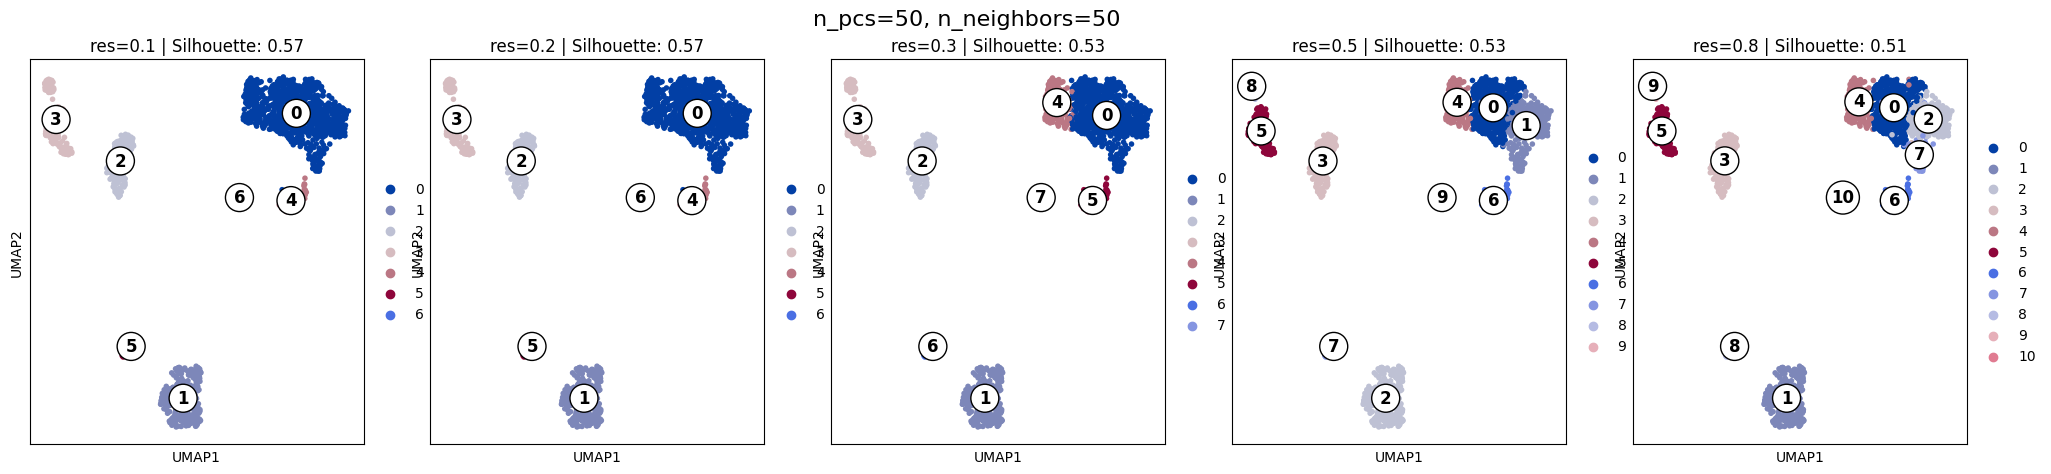

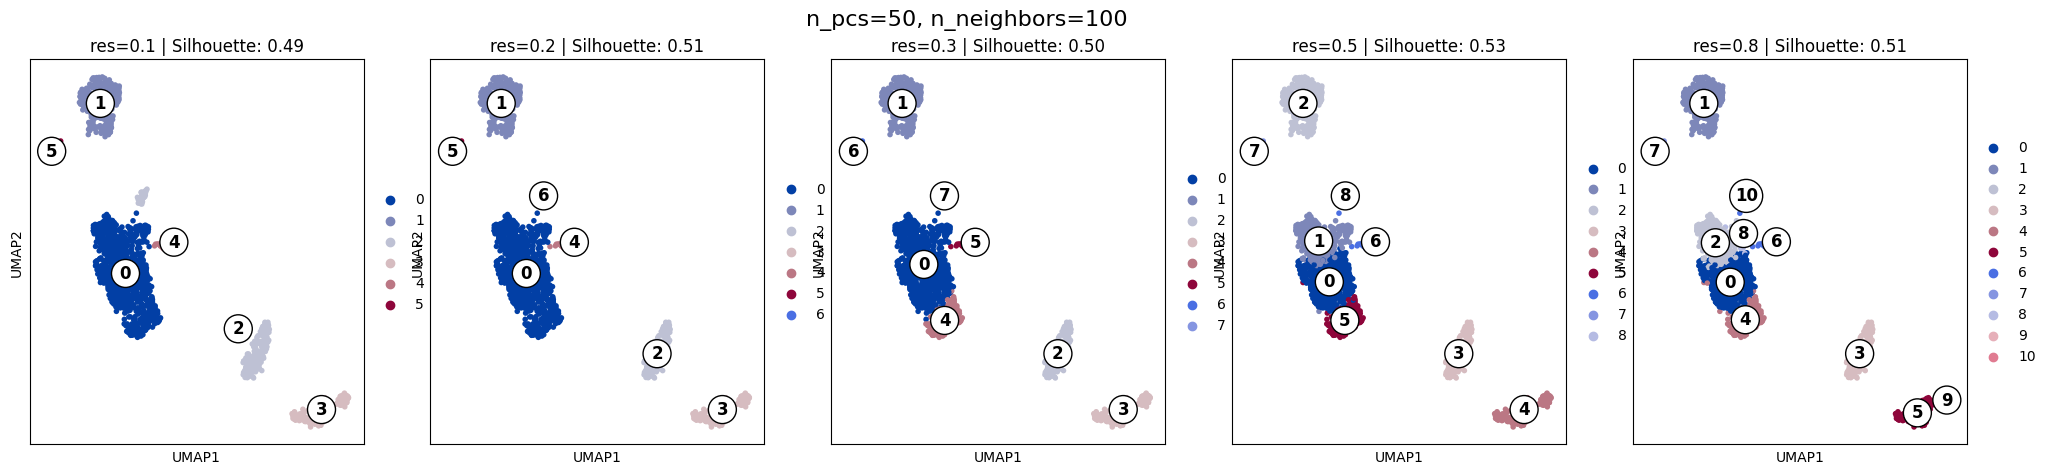

In [33]:
# Listas de parámetros a explorar
n_pcs_list = [10, 30, 50]
n_neighbors_list = [10, 20, 30, 50, 100]
resolutions = [0.1, 0.2, 0.3, 0.5, 0.8]

# Iterar sobre todas las combinaciones posibles
for n_pcs, n_neighbors in itertools.product(n_pcs_list, n_neighbors_list):
    
    # Calcular vecinos con los parámetros actuales
    sc.pp.neighbors(adata_testing, n_pcs=n_pcs, n_neighbors=n_neighbors)
    
    # Crear una figura para cada combinación de n_pcs y n_neighbors
    fig, axes = plt.subplots(1, len(resolutions), figsize=(5 * len(resolutions), 5))
    fig.suptitle(f"n_pcs={n_pcs}, n_neighbors={n_neighbors}", fontsize=16)

    for i, res in enumerate(resolutions):
        # Aplicar Leiden clustering
        sc.tl.leiden(adata_testing, resolution=res, random_state=42)
        sc.tl.umap(adata_testing)

        # Calcular el Silhouette Score
        labels = adata_testing.obs['leiden'].astype(int)  # Convertir a entero para evitar errores
        embeddings = adata_testing.obsm['X_umap']
        if len(set(labels)) > 1:  # Evitar errores si solo hay un cluster
            silhouette_avg = silhouette_score(embeddings, labels)
        else:
            silhouette_avg = -1  # Si solo hay un cluster, no tiene sentido calcularlo

        # Graficar UMAP
        sc.pl.umap(adata_testing, color='leiden', 
                   title=f"res={res} | Silhouette: {silhouette_avg:.2f}", 
                   ax=axes[i], show=False)

        # Calcular centroides de los clusters para anotarlos en el gráfico
        cluster_centroids = {}
        for cluster in set(labels):
            mask = labels == cluster
            cluster_centroids[cluster] = np.mean(embeddings[mask], axis=0)

        # Añadir etiquetas de cluster en el gráfico
        for cluster, (x, y) in cluster_centroids.items():
            axes[i].text(x, y, str(cluster), fontsize=12, weight='bold', 
                         color='black', ha='center', va='center', 
                         bbox=dict(facecolor='white', edgecolor='black', boxstyle='circle,pad=0.3'))

    # Mostrar los gráficos de esta configuración
    plt.show()

## Selección

Elijo aquellos parametros que tienen el valor más alto de Silhouette score

### Silhouette score 0.63

- n_pcs 30: bastante coherente con lo mostrado inicialmente, entre 20 y 30 se aplanaba la curva así que sería coherente
- n_neigbors 30
- resolution 0.1/0.2: Si se aumenta la resolución se clusteriza aún más. Inicialmente trabajaré con una resolución muy baja para poder encontrar un tipo de célula por cluster.

Se puede observar que una resolución mayor a 0.8 agrega ruido al análisis unicamente como también lleva al análisis a una sobreclusterización

## Elección de la parametrizacón

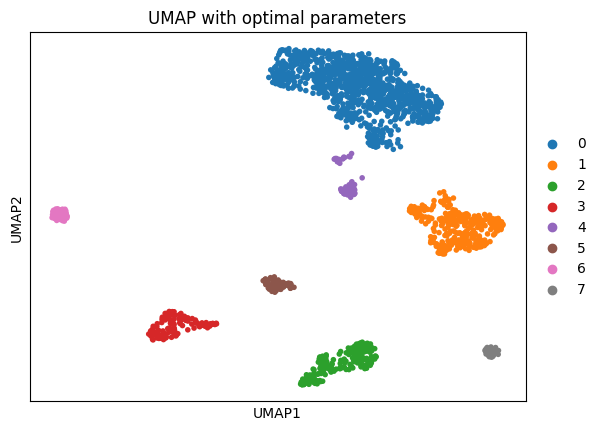

In [34]:
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
sc.tl.leiden(adata, resolution=0.1)
sc.tl.umap(adata)
sc.pl.umap(adata, color='leiden', title="UMAP with optimal parameters")

Observo una clusterización muy razonable con separación de los clusters de manera muy limpia y con silhouette score bastante razonable

In [35]:
# Limitar el análisis a los primeros 30 componentes principales
adata.obsm['X_pca'] = adata.obsm['X_pca'][:, :30]

# Confirmar la nueva forma de los datos PCA
print(f"Nueva forma de los datos PCA (30 componentes): {adata.obsm['X_pca'].shape}")

Nueva forma de los datos PCA (30 componentes): (1871, 30)


In [36]:
adata

AnnData object with n_obs × n_vars = 1871 × 20615
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'total_UMIs', 'doublet_score', 'predicted_doublet', 'leiden'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

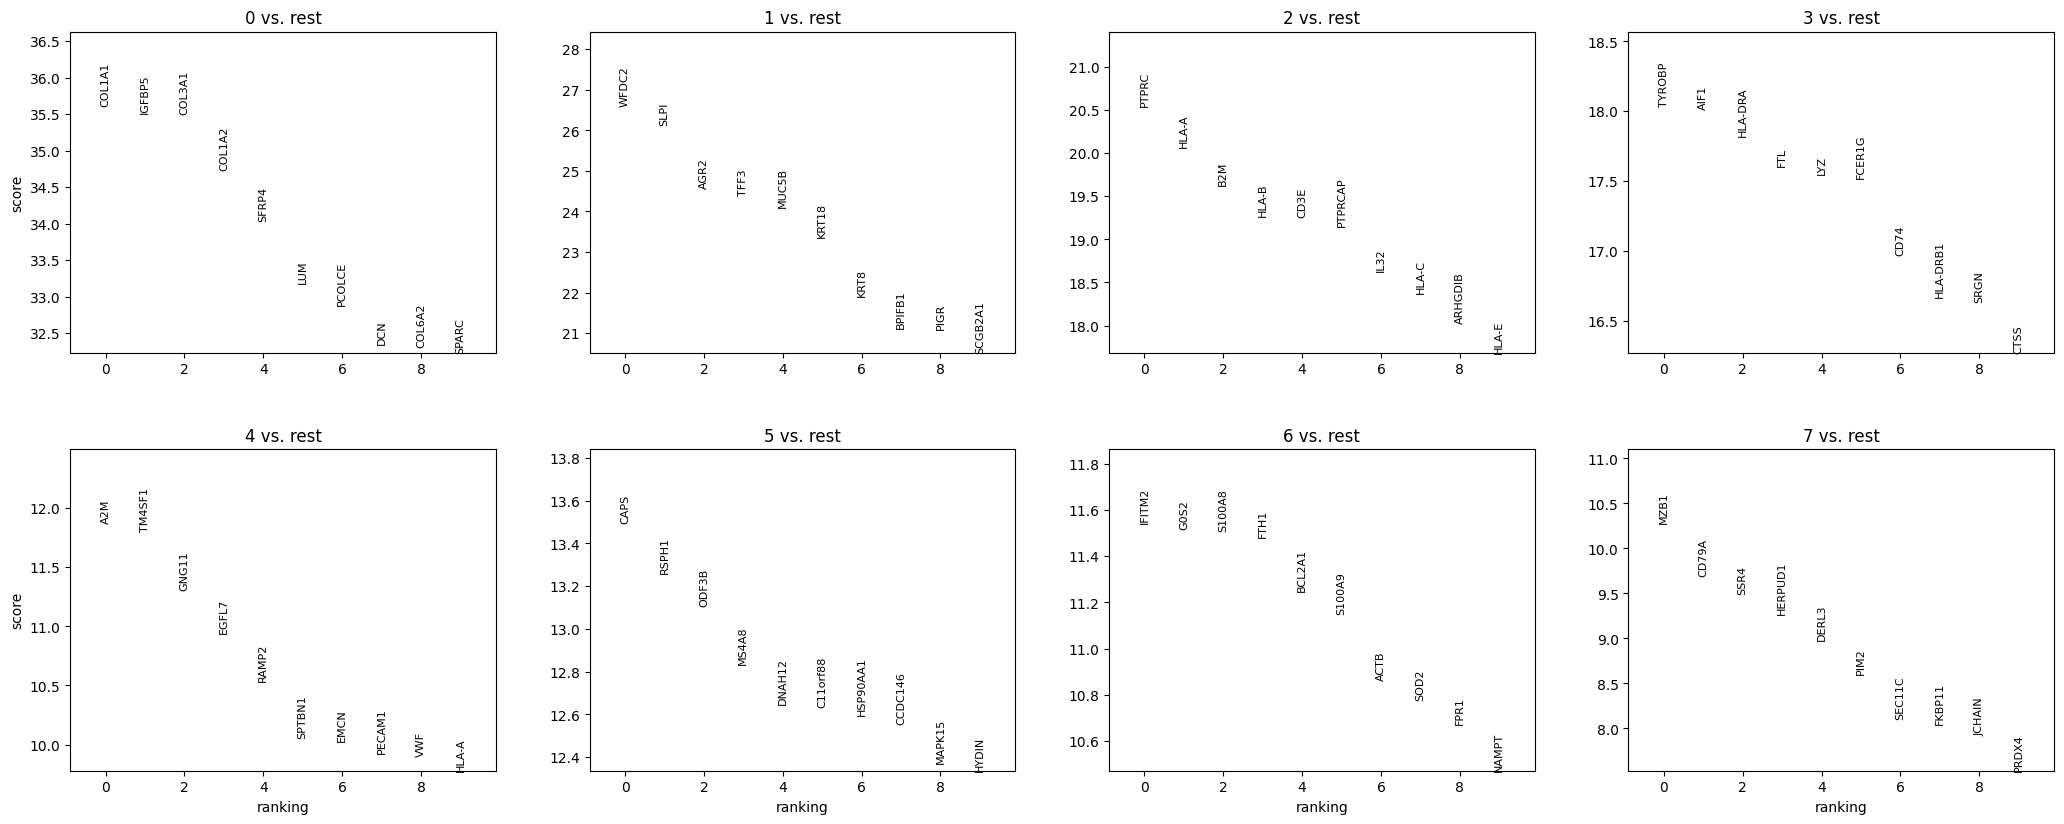

In [37]:
# Calcular genes diferenciales usando Wilcoxon
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")

# Visualizar los principales genes marcadores
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

In [38]:
adata

AnnData object with n_obs × n_vars = 1871 × 20615
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'total_UMIs', 'doublet_score', 'predicted_doublet', 'leiden'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [39]:
print(adata.uns['rank_genes_groups'].keys())

dict_keys(['params', 'names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges'])


In [63]:
# Mostrar los genes principales para cada grupo
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

0        1        2         3       4         5       6        7
0  COL1A1    WFDC2    PTPRC    TYROBP     A2M      CAPS  IFITM2     MZB1
1  IGFBP5     SLPI    HLA-A      AIF1  TM4SF1     RSPH1    G0S2    CD79A
2  COL3A1     AGR2      B2M   HLA-DRA   GNG11     ODF3B  S100A8     SSR4
3  COL1A2     TFF3    HLA-B       FTL   EGFL7     MS4A8    FTH1  HERPUD1
4   SFRP4    MUC5B     CD3E       LYZ   RAMP2    DNAH12  BCL2A1    DERL3
5     LUM    KRT18  PTPRCAP    FCER1G  SPTBN1  C11orf88  S100A9     PIM2
6  PCOLCE     KRT8     IL32      CD74    EMCN  HSP90AA1    ACTB   SEC11C
7     DCN   BPIFB1    HLA-C  HLA-DRB1  PECAM1   CCDC146    SOD2   FKBP11
8  COL6A2     PIGR  ARHGDIB      SRGN     VWF    MAPK15    FPR1   JCHAIN
9   SPARC  SCGB2A1    HLA-E      CTSS   HLA-A     HYDIN   NAMPT    PRDX4

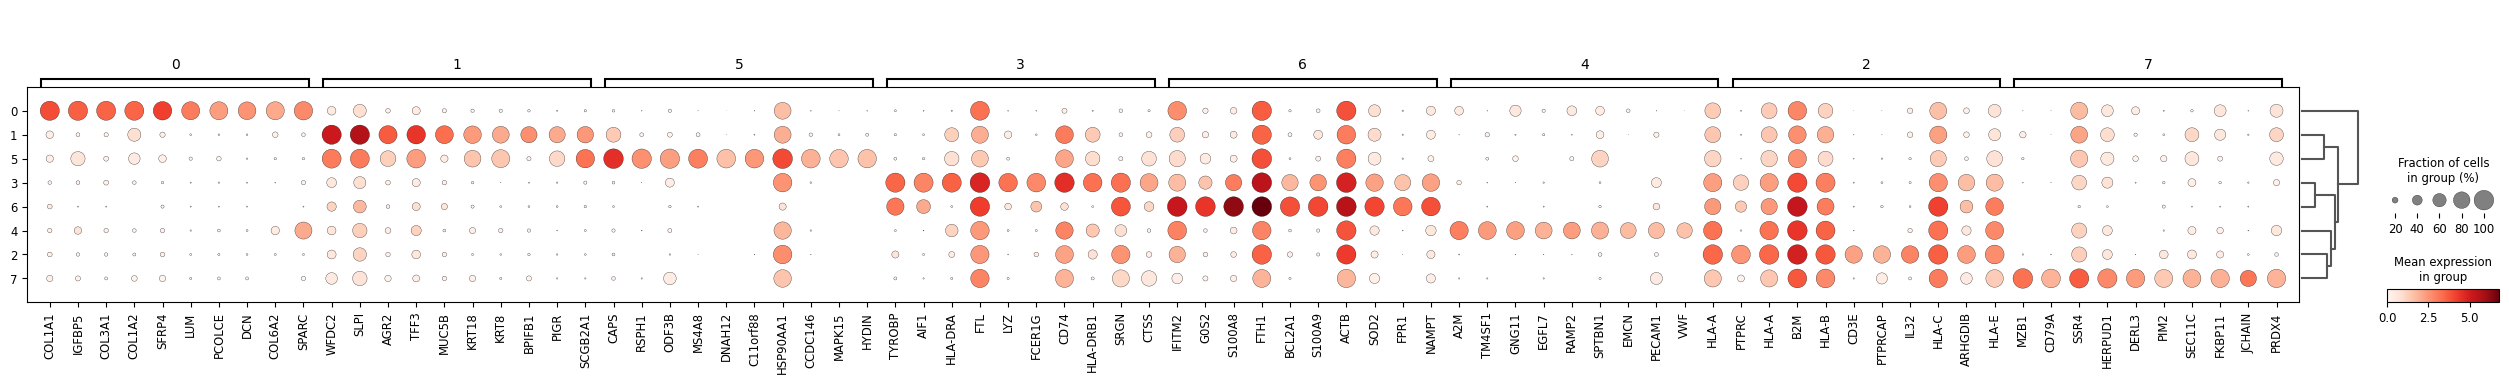

In [64]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=10)

Para facilitar la interpretación, reduzco el número de genes mostrados (top 5)

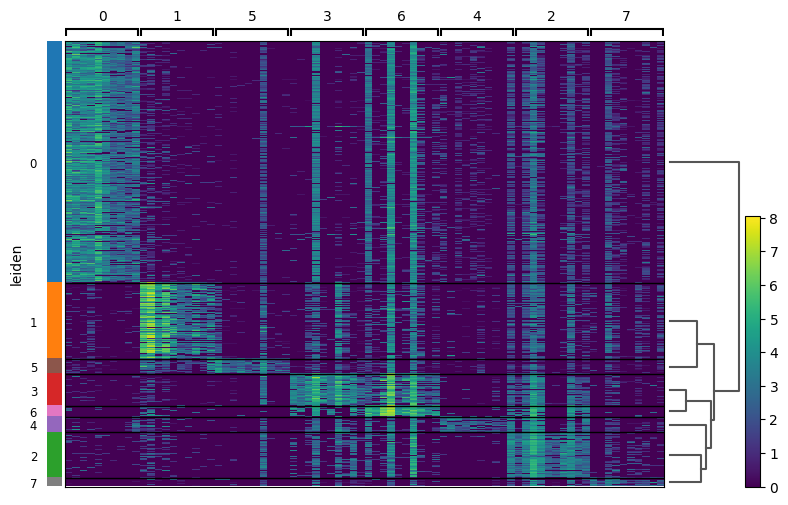

In [66]:
sc.tl.dendrogram(adata, groupby='leiden')
sc.pl.rank_genes_groups_heatmap(adata, n_genes=10, groupby='leiden', show=True)

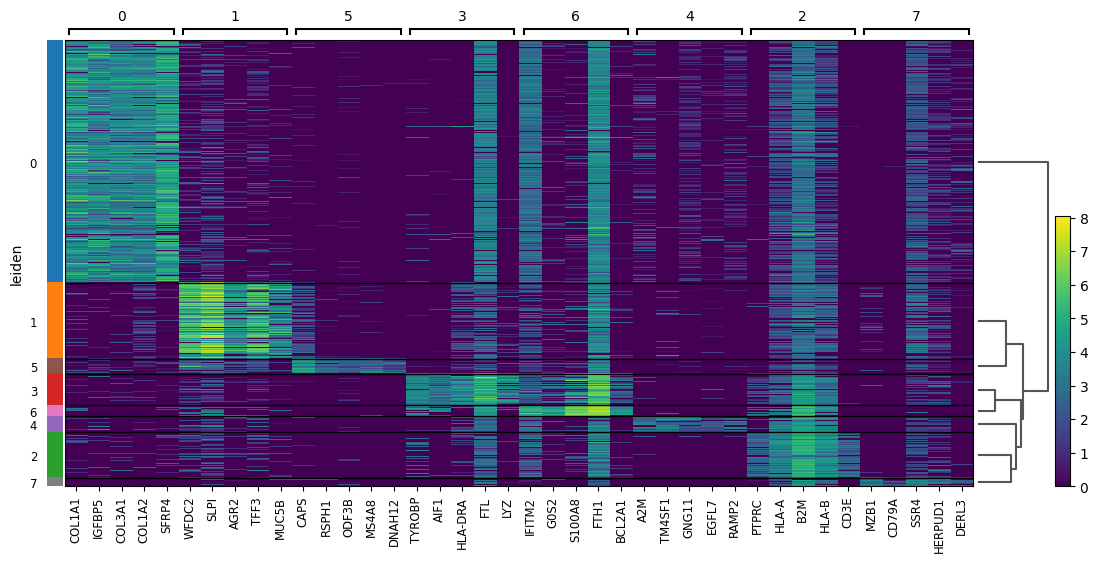

In [67]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, groupby='leiden', show=True)

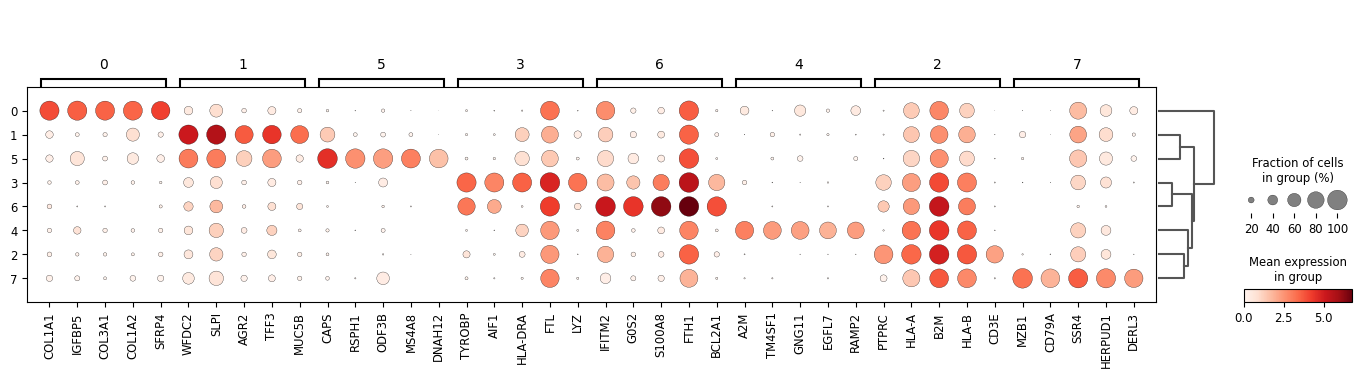

In [57]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, groupby='leiden', show=True)

In [69]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names

# Crear un DataFrame con los genes diferenciales
df = pd.DataFrame({group: result['names'][group] for group in groups})
print(df.head(10))


# Crear un DataFrame con los genes diferenciales (ya lo tienes hecho)
df = pd.DataFrame({group: result['names'][group] for group in groups})

# Exportar el DataFrame a un archivo CSV
df.to_csv('./HPV18_results/genes_diferenciales18.csv', index=False)

        0        1        2         3       4         5       6        7
0  COL1A1    WFDC2    PTPRC    TYROBP     A2M      CAPS  IFITM2     MZB1
1  IGFBP5     SLPI    HLA-A      AIF1  TM4SF1     RSPH1    G0S2    CD79A
2  COL3A1     AGR2      B2M   HLA-DRA   GNG11     ODF3B  S100A8     SSR4
3  COL1A2     TFF3    HLA-B       FTL   EGFL7     MS4A8    FTH1  HERPUD1
4   SFRP4    MUC5B     CD3E       LYZ   RAMP2    DNAH12  BCL2A1    DERL3
5     LUM    KRT18  PTPRCAP    FCER1G  SPTBN1  C11orf88  S100A9     PIM2
6  PCOLCE     KRT8     IL32      CD74    EMCN  HSP90AA1    ACTB   SEC11C
7     DCN   BPIFB1    HLA-C  HLA-DRB1  PECAM1   CCDC146    SOD2   FKBP11
8  COL6A2     PIGR  ARHGDIB      SRGN     VWF    MAPK15    FPR1   JCHAIN
9   SPARC  SCGB2A1    HLA-E      CTSS   HLA-A     HYDIN   NAMPT    PRDX4


In [70]:
# Verifica el tipo de matriz
print(type(adata.X))

# Si es sparse, conviértela a densa
if sparse.issparse(adata.X):
    adata.X = adata.X.toarray()

# Verifica nuevamente la forma
print(adata.X.shape)

<class 'numpy.ndarray'>
(1871, 20615)


In [71]:
# Crear el DataFrame directamente usando adata.X
expression_matrix = pd.DataFrame(
    adata.X.T,  # Transponer para que los genes estén en las filas
    index=adata.var_names,  # Los nombres de los genes (filas)
    columns=adata.obs_names  # Los nombres de las células (columnas)
)

# Exportar el DataFrame como CSV
expression_matrix.to_csv("./HPV18_results/18_QC2_expression_matrix.csv")

# Exportar los metadatos, incluidos los clusters Leiden
metadata = adata.obs['leiden']
metadata.to_csv("./HPV18_results/18_QC2_metadata.csv")

In [72]:
# Leer los archivos exportados
expression_matrix = pd.read_csv("./HPV18_results/18_QC2_expression_matrix.csv", index_col=0)
metadata = pd.read_csv("./HPV18_results/18_QC2_metadata.csv", index_col=0)

# Verificar las dimensiones
print(expression_matrix.shape)
print(metadata.shape)

# Inspeccionar las primeras filas de ambos archivos
print(expression_matrix.head())
print(metadata.head())

(20615, 1871)
(1871, 1)
        AAACCTGAGAATGTTG-1  AAACGGGAGCCCAACC-1  AAACGGGAGGTACTCT-1  \
OR4F5             0.000000            0.000000                 0.0   
OR4F29            0.000000            0.000000                 0.0   
OR4F16            0.000000            0.000000                 0.0   
SAMD11            0.000000            0.000000                 0.0   
NOC2L             0.580659            1.934005                 0.0   

        AAACGGGCACTCGACG-1  AAACGGGCAGGGTATG-1  AAACGGGGTAGTACCT-1  \
OR4F5              0.00000            0.000000            0.000000   
OR4F29             0.00000            0.000000            0.000000   
OR4F16             0.00000            0.000000            0.000000   
SAMD11             0.00000            0.000000            0.000000   
NOC2L              0.54523            0.426777            1.591132   

        AAACGGGTCATGCAAC-1  AAAGATGAGAGGTTAT-1  AAAGATGCAGTAGAGC-1  \
OR4F5                  0.0                 0.0                 0

In [74]:
## Pruebas realizadas para ver cómo se comportaba con otras resoluciones

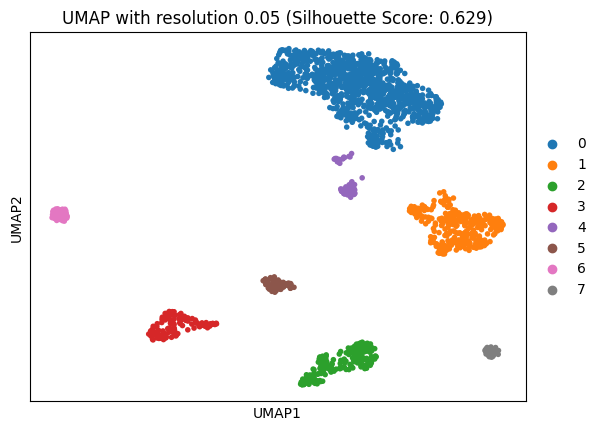

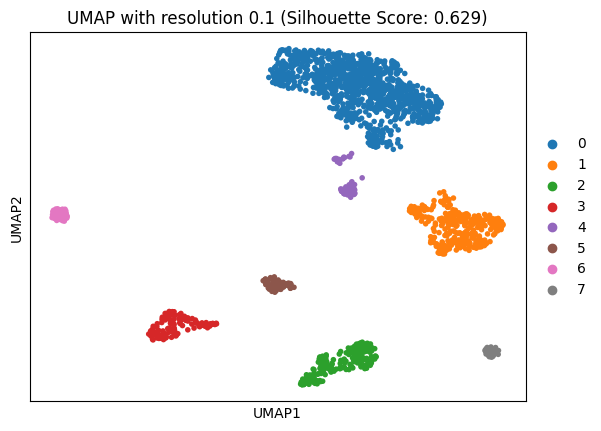

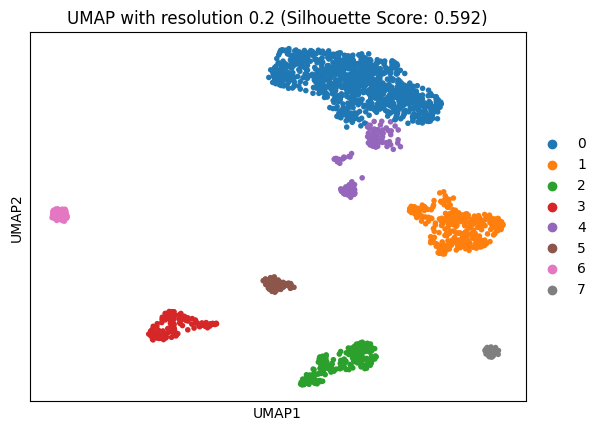

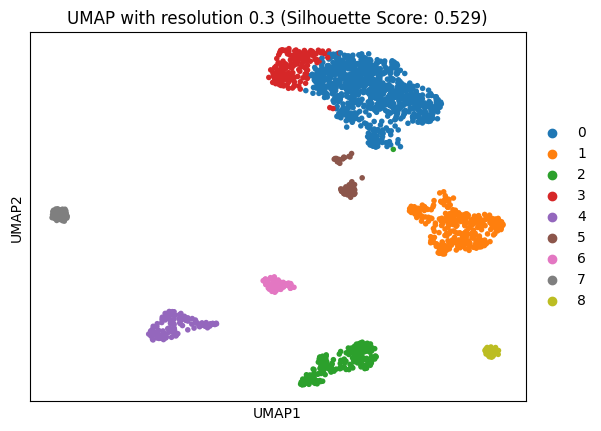

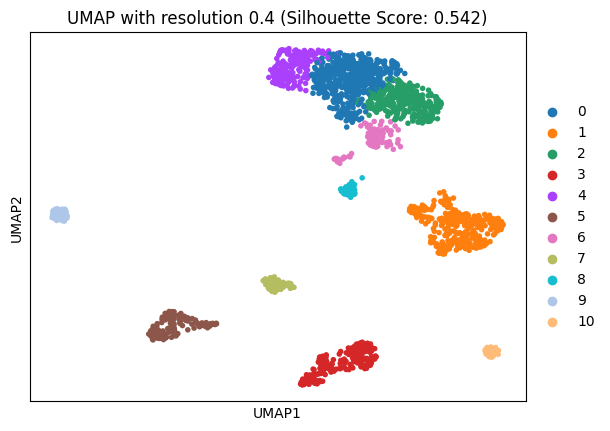

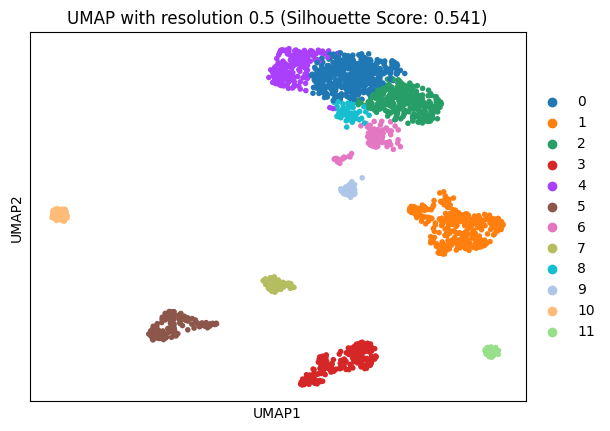

In [75]:
resolution_list = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

for resolution in resolution_list:
    sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
    sc.tl.leiden(adata, resolution=resolution)
    sc.tl.umap(adata)
    
    # Obtener las coordenadas del UMAP y las etiquetas de clusters
    umap_coords = adata.obsm["X_umap"]
    cluster_labels = adata.obs["leiden"].astype(int)  # Convertir etiquetas a enteros
    
    # Calcular Silhouette Score
    score = silhouette_score(umap_coords, cluster_labels)
    
    # Graficar UMAP con el Silhouette Score en el título
    sc.pl.umap(adata, color="leiden", title=f"UMAP with resolution {resolution} (Silhouette Score: {score:.3f})")


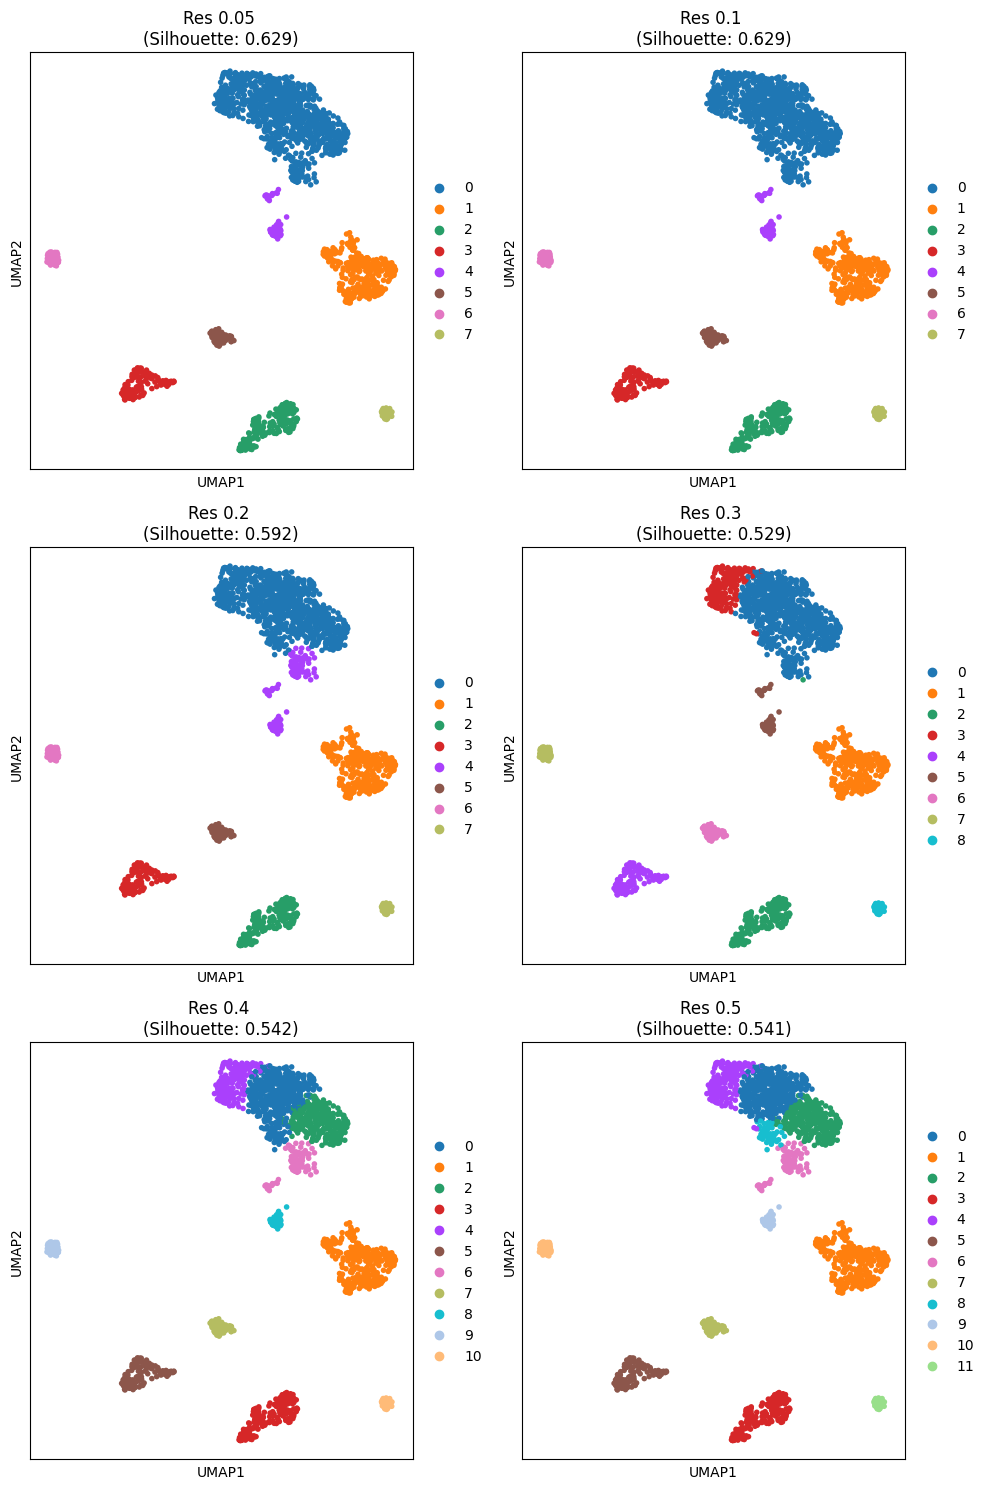

In [76]:
resolution_list = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

# Definir el número de columnas por fila
num_cols = 2
num_rows = -(-len(resolution_list) // num_cols)  # Redondeo hacia arriba para obtener las filas necesarias

# Crear figura con subgráficos en múltiples filas
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5))

# Aplanar el array de ejes para facilitar la iteración
axes = axes.flatten()

for i, (ax, resolution) in enumerate(zip(axes, resolution_list)):
    sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
    sc.tl.leiden(adata, resolution=resolution)
    sc.tl.umap(adata)
    
    # Obtener las coordenadas del UMAP y las etiquetas de clusters
    umap_coords = adata.obsm["X_umap"]
    cluster_labels = adata.obs["leiden"].astype(int)  # Convertir etiquetas a enteros
    
    # Calcular Silhouette Score
    score = silhouette_score(umap_coords, cluster_labels)
    
    # Graficar UMAP en la fila de subplots
    sc.pl.umap(adata, color="leiden", title=f"Res {resolution} \n(Silhouette: {score:.3f})", ax=ax, show=False)

# Eliminar cualquier subplot vacío si el número de resoluciones no es par
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar el layout para evitar solapamientos
plt.tight_layout()
plt.show()

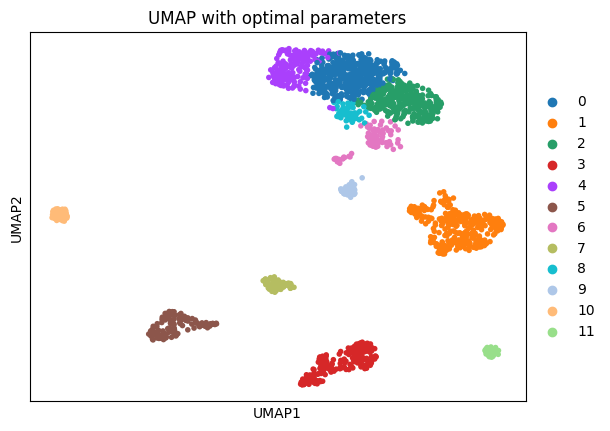

In [77]:
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
sc.tl.leiden(adata, resolution=0.5)
sc.tl.umap(adata)
sc.pl.umap(adata, color='leiden', title="UMAP with optimal parameters")

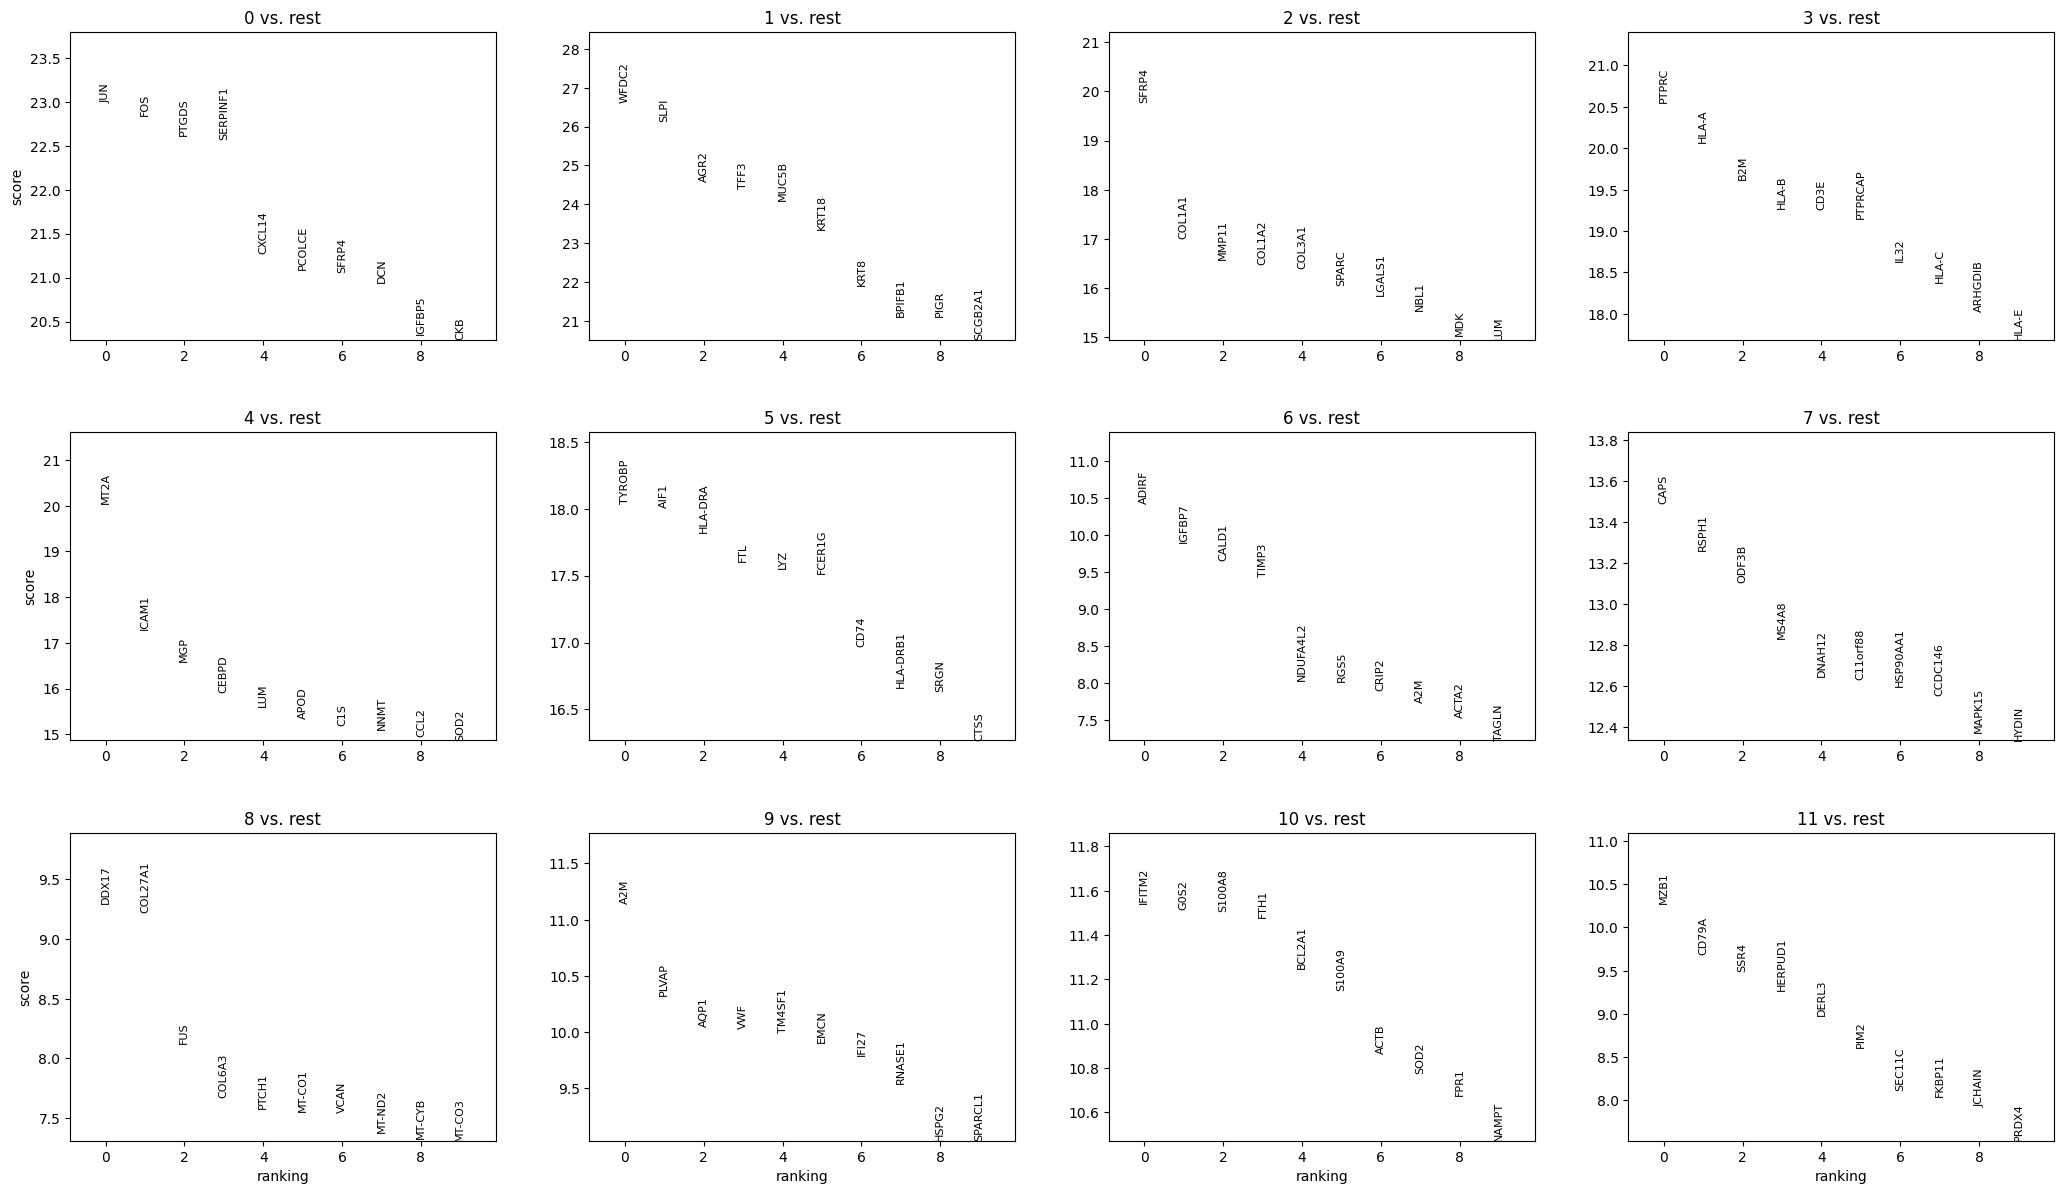

In [78]:
# Calcular genes diferenciales usando Wilcoxon
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")

# Visualizar los principales genes marcadores
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

In [79]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names

# Crear un DataFrame con los genes diferenciales
df = pd.DataFrame({group: result['names'][group] for group in groups})
print(df.head(10))

          0        1       2        3      4         5         6         7  \
0       JUN    WFDC2   SFRP4    PTPRC   MT2A    TYROBP     ADIRF      CAPS   
1       FOS     SLPI  COL1A1    HLA-A  ICAM1      AIF1    IGFBP7     RSPH1   
2     PTGDS     AGR2   MMP11      B2M    MGP   HLA-DRA     CALD1     ODF3B   
3  SERPINF1     TFF3  COL1A2    HLA-B  CEBPD       FTL     TIMP3     MS4A8   
4    CXCL14    MUC5B  COL3A1     CD3E    LUM       LYZ  NDUFA4L2    DNAH12   
5    PCOLCE    KRT18   SPARC  PTPRCAP   APOD    FCER1G      RGS5  C11orf88   
6     SFRP4     KRT8  LGALS1     IL32    C1S      CD74     CRIP2  HSP90AA1   
7       DCN   BPIFB1    NBL1    HLA-C   NNMT  HLA-DRB1       A2M   CCDC146   
8    IGFBP5     PIGR     MDK  ARHGDIB   CCL2      SRGN     ACTA2    MAPK15   
9       CKB  SCGB2A1     LUM    HLA-E   SOD2      CTSS     TAGLN     HYDIN   

         8        9      10       11  
0    DDX17      A2M  IFITM2     MZB1  
1  COL27A1    PLVAP    G0S2    CD79A  
2      FUS     AQP1  S10

In [80]:
# Verifica el tipo de matriz
print(type(adata.X))

# Si es sparse, conviértela a densa
if sparse.issparse(adata.X):
    adata.X = adata.X.toarray()

# Verifica nuevamente la forma
print(adata.X.shape)

<class 'numpy.ndarray'>
(1871, 20615)


In [81]:
# Crear el DataFrame directamente usando adata.X
expression_matrix = pd.DataFrame(
    adata.X.T,  # Transponer para que los genes estén en las filas
    index=adata.var_names,  # Los nombres de los genes (filas)
    columns=adata.obs_names  # Los nombres de las células (columnas)
)

# Exportar el DataFrame como CSV
expression_matrix.to_csv("./HPV18_results/18_QC2_expression_matrix_res05.csv")

# Exportar los metadatos, incluidos los clusters Leiden
metadata = adata.obs['leiden']
metadata.to_csv("./HPV18_results/18_QC2_metadata_res05.csv")

In [82]:
# Leer los archivos exportados
expression_matrix = pd.read_csv("./HPV18_results/18_QC2_expression_matrix_res05.csv", index_col=0)
metadata = pd.read_csv("./HPV18_results/18_QC2_metadata_res05.csv", index_col=0)

# Verificar las dimensiones
print(expression_matrix.shape)
print(metadata.shape) 

# Inspeccionar las primeras filas de ambos archivos
print(expression_matrix.head())
print(metadata.head())

(20615, 1871)
(1871, 1)
        AAACCTGAGAATGTTG-1  AAACGGGAGCCCAACC-1  AAACGGGAGGTACTCT-1  \
OR4F5             0.000000            0.000000                 0.0   
OR4F29            0.000000            0.000000                 0.0   
OR4F16            0.000000            0.000000                 0.0   
SAMD11            0.000000            0.000000                 0.0   
NOC2L             0.580659            1.934005                 0.0   

        AAACGGGCACTCGACG-1  AAACGGGCAGGGTATG-1  AAACGGGGTAGTACCT-1  \
OR4F5              0.00000            0.000000            0.000000   
OR4F29             0.00000            0.000000            0.000000   
OR4F16             0.00000            0.000000            0.000000   
SAMD11             0.00000            0.000000            0.000000   
NOC2L              0.54523            0.426777            1.591132   

        AAACGGGTCATGCAAC-1  AAAGATGAGAGGTTAT-1  AAAGATGCAGTAGAGC-1  \
OR4F5                  0.0                 0.0                 0

In [83]:
## Para contar la cantidad de células que tiene cada cluster

In [84]:
# Leer el archivo de metadatos
metadata = pd.read_csv("./HPV18_results/18_QC2_metadata.csv", index_col=0)

# Contar cuántas células hay en cada clúster
celulas_por_cluster = metadata["leiden"].value_counts().sort_index()

# Mostrar el número de células por clúster
print("Número de células por clúster:")
print(celulas_por_cluster)

# Total de células en el dataset
total_celulas = celulas_por_cluster.sum()
print("\nTotal de células en el dataset:", total_celulas)

Número de células por clúster:
leiden
0    1017
1     319
2     192
3     133
4      65
5      63
6      46
7      36
Name: count, dtype: int64

Total de células en el dataset: 1871
